# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *
from parsers import extract_FOV_area

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main'  # Analysis type
mouseline = 'pv'  # mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False
plot_traces = False
do_nonstat_correct = True

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 30/06/2023 18:39:22: assembling batch analysis settings...
 30/06/2023 18:39:22: pv main analysis notebook started on 2023-06-30 at 18:39:22


### Input summary table figure

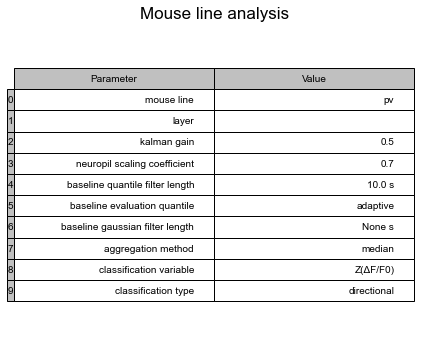

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional"
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [6]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

 30/06/2023 18:39:22: loading data from /Users/tlemaire/Documents/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/pv:
 30/06/2023 18:39:22: loading mouse-region data from 20190606_mouse2_region1.h5
 30/06/2023 18:39:22: loading mouse-region data from 20190606_mouse2_region2.h5
 30/06/2023 18:39:22: loading mouse-region data from 20190629_mouse2_region1.h5
 30/06/2023 18:39:22: loading mouse-region data from 20190630_mouse3_region1.h5
 30/06/2023 18:39:23: loading mouse-region data from 20190702_mouse1_region1.h5
 30/06/2023 18:39:23: loading mouse-region data from 20190702_mouse5_region1.h5
 30/06/2023 18:39:23: loading mouse-region data from 20190703_mouse4_region1.h5
 30/06/2023 18:39:23: loading mouse-region data from 20190821_mouse3_region1.h5
 30/06/2023 18:39:23: loading mouse-region data from 20190821_mouse6_region1.h5
 30/06/2023 18:39:23: loading mouse-region d

### Unpack data and get ROI counts

In [7]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 30/06/2023 18:39:27: extracting timeseries and stats from data...
 30/06/2023 18:39:27: detailed ROI count:


### Inspect cell maps and exclude outlier datasets 

 30/06/2023 18:39:28: sorted cell densities:
dataset
20190630_mouse3_region1    188.982416
20190629_mouse2_region1    295.285024
20190703_mouse4_region1    295.285024
20190821_mouse3_region1    334.656361
20190821_mouse7_region1    389.776232
20190702_mouse5_region1    417.336168
20190606_mouse2_region2    468.518905
20190606_mouse2_region1    484.267440
20190821_mouse6_region1    551.198712
20190702_mouse1_region1    696.872657
dtype: float64
 30/06/2023 18:39:28: plotting cell maps...


100%|██████████| 10/10 [00:00<00:00, 15.32it/s]

 30/06/2023 18:39:28: empty exclude list -> ignoring


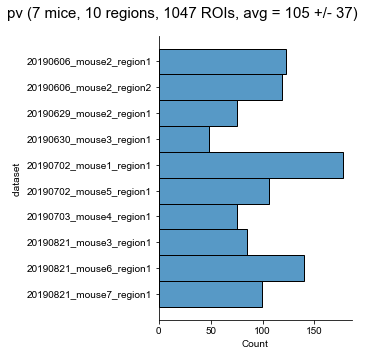

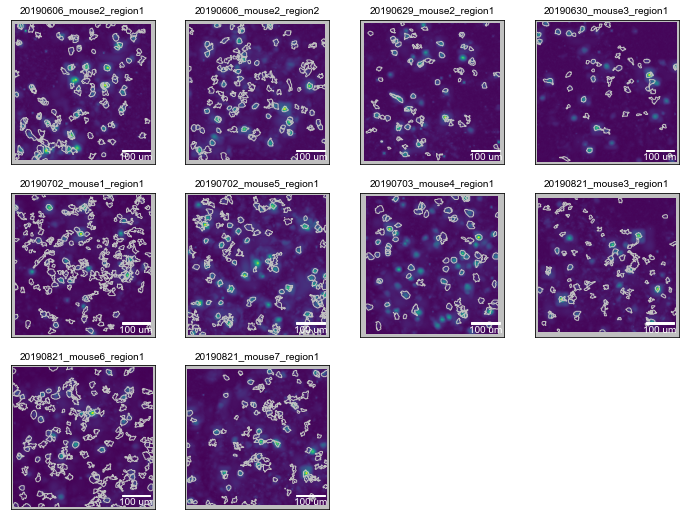

In [8]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# If threshold on cell density is specified, exclude datasets with densities below threshold 
from constants import MIN_CELL_DENSITY
outliers = None
if MIN_CELL_DENSITY[mouseline] is not None:
    isoutlier = ROI_densities < MIN_CELL_DENSITY[mouseline]
    outliers = isoutlier[isoutlier].index.values.tolist()
    if len(outliers) > 0:
        logger.warning(f'datasets with abnormally low cell density::\n{pprint.pformat(outliers)}')
    figs['cellcounts'].axes[0].axvline(
        MIN_CELL_DENSITY[mouseline] * FOV_areas.mean(), c='k', ls='--')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour', hue=None, 
    outliers=outliers)

# Exclude outlier datasets
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=outliers)

### Inspect baseline variation throughout experiments

 30/06/2023 18:39:29: inspecting relative variations in baseline fluorescence across experiments...
 30/06/2023 18:39:29: maximal relative FO deviations:
dataset
20190606_mouse2_region1    0.024403
20190606_mouse2_region2    0.038959
20190821_mouse6_region1    0.043440
20190630_mouse3_region1    0.058019
20190702_mouse1_region1    0.131103
20190629_mouse2_region1    0.155923
20190821_mouse7_region1    0.161459
20190702_mouse5_region1    0.173311
20190703_mouse4_region1    0.240634
20190821_mouse3_region1    0.285766
Name: rel F0 (a.u.), dtype: float64
 30/06/2023 18:39:29: identified 2 datasets with abnormal baseline fluorescence variations:
  - 20190703_mouse4_region1
  - 20190821_mouse3_region1
 30/06/2023 18:39:29: excluding the following datasets from analysis:
 - 20190703_mouse4_region1
 - 20190821_mouse3_region1
 30/06/2023 18:39:29: 8 datasets remaining


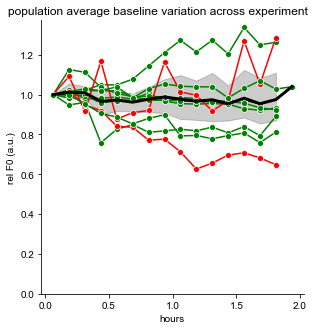

In [9]:
from constants import MAX_F0_REL_DEV
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Compute relative deviations of relative baseline fluorescence from its mean value,
# for each dataset
popagg_relF0_mean = popagg_F0_per_run[relF0_key].groupby(Label.DATASET).mean()
popagg_relF0_reldevs = ((popagg_F0_per_run[relF0_key] - popagg_relF0_mean) / popagg_relF0_mean).abs()

# Identify datasets that have at least 1 large F0 relative deviation from mean
max_popagg_relF0_reldevs = popagg_relF0_reldevs.groupby(Label.DATASET).max()
logger.info(f'maximal relative FO deviations:\n{max_popagg_relF0_reldevs.sort_values()}')
is_relF0_outlier = max_popagg_relF0_reldevs > MAX_F0_REL_DEV

# Extract datasets with at least 1 outlier run
relF0_outliers = is_relF0_outlier[is_relF0_outlier].index.unique(Label.DATASET).values.tolist()

# Remove potential outlier datasets
nouts = len(relF0_outliers)
palette = None
if nouts > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {nouts} datasets with abnormal baseline fluorescence variations:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=relF0_outliers)
    palette = get_binary_palette(popagg_F0_per_run, relF0_outliers)

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    ci=None, 
    hue=Label.DATASET,
    marker='o',
    palette=palette,
    legend=palette is None,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    # ax.axhline(1 - MAX_F0_REL_VAR, ls='--', c='k')
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run.drop(relF0_outliers),
        lw=3, color='k', legend=False, **pltkwargs
    )

### Inspect run presentation order per dataset and potential consequences on evoked activity

 30/06/2023 18:39:30: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 30/06/2023 18:39:30: run ID not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:39:30: sub-indexing data...
 30/06/2023 18:39:30: filtering data...
 30/06/2023 18:39:30: cross-checking filters...
 30/06/2023 18:39:30: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 30/06/2023 18:39:30: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 30/06/2023 18:39:30: run ID not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:39:30: sub-indexing data...
 30/06/2023 18:39:30: filtering data...
 30/06/2023 18:39:30: cross-checking filters...
 30/06/2023 18:39:30: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. run ID ...
 30/06/2023 18:39:30: plotting evoked Z(ΔF/F0) change run sequence dependency across dataset...
 30/06/2023 18:39:30: run ID not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:39:30: sub-ind

dataset 20190606_mouse2_region1 20190606_mouse2_region2  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_50%DC   
1                 0.80MPa_40%DC           0.80MPa_40%DC   
2                 0.80MPa_30%DC           0.80MPa_30%DC   
3                 0.80MPa_20%DC           0.80MPa_20%DC   
4                 0.80MPa_10%DC           0.80MPa_10%DC   
5                 0.80MPa_05%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.00MPa_50%DC   
7                 0.60MPa_50%DC                     NaN   
8                 0.40MPa_50%DC                     NaN   
9                 0.20MPa_50%DC                     NaN   
10                          NaN                     NaN   
11                          NaN           0.60MPa_50%DC   
12                          NaN           0.40MPa_50%DC   
13                          NaN           0.20MPa_50%DC   
14                          NaN                     NaN   
15                          NaN                     NaN   

dataset 20190629_mouse2_region1 20190630_mouse3_region1  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_50%DC   
1                 0.80MPa_40%DC           0.80MPa_40%DC   
2                 0.80MPa_30%DC           0.80MPa_30%DC   
3                 0.80MPa_20%DC           0.80MPa_20%DC   
4                 0.80MPa_10%DC           0.80MPa_10%DC   
5                 0.80MPa_05%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.00MPa_50%DC   
7                 0.60MPa_50%DC           0.60MPa_50%DC   
8                 0.40MPa_50%DC           0.40MPa_50%DC   
9                 0.20MPa_50%DC           0.20MPa_50%DC   
10                0.10MPa_50%DC           0.10MPa_50%DC   
11                0.80MPa_60%DC           0.05MPa_50%DC   
12                0.80MPa_70%DC           0.80MPa_60%DC   
13                0.80MPa_80%DC           0.80MPa_70%DC   
14                0.05MPa_50%DC           0.80MPa_80%DC   
15                          NaN                     NaN   

dataset 20190702_mouse1_region1 20190702_mouse5_region1  \
run ID                                                    
0                 0.80MPa_50%DC           0.80MPa_50%DC   
1                 0.80MPa_40%DC           0.80MPa_40%DC   
2                 0.80MPa_30%DC           0.80MPa_30%DC   
3                 0.80MPa_20%DC           0.80MPa_20%DC   
4                 0.80MPa_10%DC           0.80MPa_10%DC   
5                 0.80MPa_05%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.00MPa_50%DC   
7                 0.60MPa_50%DC           0.60MPa_50%DC   
8                 0.40MPa_50%DC           0.40MPa_50%DC   
9                 0.20MPa_50%DC           0.20MPa_50%DC   
10                0.10MPa_50%DC           0.10MPa_50%DC   
11                0.05MPa_50%DC           0.05MPa_50%DC   
12                0.80MPa_60%DC           0.80MPa_60%DC   
13                0.80MPa_70%DC           0.80MPa_70%DC   
14                0.80MPa_80%DC           0.80MPa_80%DC   
15                          NaN                     NaN   

dataset 20190821_mouse6_region1 20190821_mouse7_region1  
run ID                                                   
0                 0.80MPa_50%DC           0.80MPa_50%DC  
1                           NaN           0.80MPa_40%DC  
2                 0.80MPa_40%DC           0.80MPa_30%DC  
3                 0.80MPa_30%DC           0.80MPa_20%DC  
4                 0.80MPa_20%DC           0.80MPa_10%DC  
5                 0.80MPa_10%DC           0.80MPa_05%DC  
6                 0.80MPa_05%DC           0.60MPa_50%DC  
7                 0.80MPa_60%DC           0.40MPa_50%DC  
8                 0.80MPa_70%DC           0.20MPa_50%DC  
9                 0.80MPa_80%DC           0.10MPa_50%DC  
10                0.60MPa_50%DC           0.05MPa_50%DC  
11                0.40MPa_50%DC           0.00MPa_50%DC  

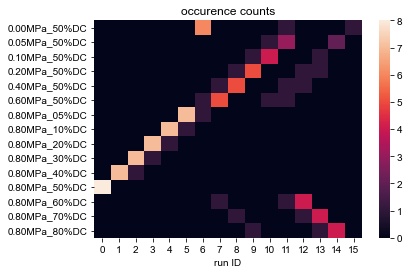

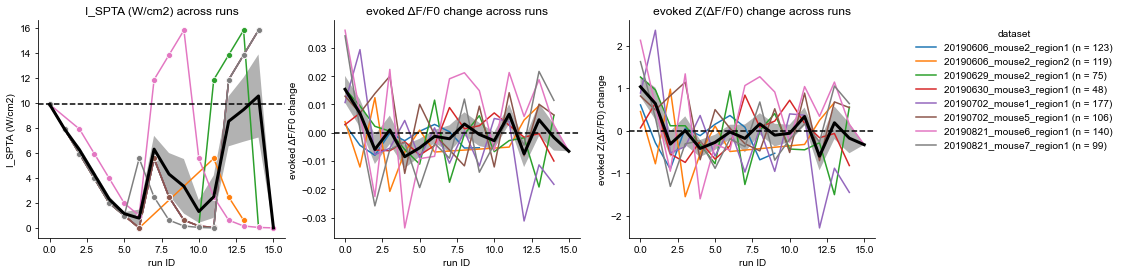

In [10]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
sns.heatmap(data=params_counts, ax=ax)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykeys_seq = [Label.ISPTA, get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        ci=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='o' if ykey == Label.ISPTA else None,
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Inspect initial parameter dependency curves

 30/06/2023 18:39:30: sub-indexing data...
 30/06/2023 18:39:30: filtering data...
 30/06/2023 18:39:30: cross-checking filters...
 30/06/2023 18:39:30: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 30/06/2023 18:39:30: sub-indexing data...
 30/06/2023 18:39:30: filtering data...
 30/06/2023 18:39:30: cross-checking filters...
 30/06/2023 18:39:30: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 30/06/2023 18:39:30: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:39:30: sub-indexing data...
 30/06/2023 18:39:30: filtering data...
 30/06/2023 18:39:30: cross-checking filters...
 30/06/2023 18:39:31: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. I_SPTA (W/cm2) ...
 30/06/2023 18:39:31: sub-indexing data...
 30/06/2023 18:39:31: filtering data...
 30/06/2023 18:39:31: cross-checking filters...
 30/06/2023 18:39:31: grouping by dataset, averaging and plotting 

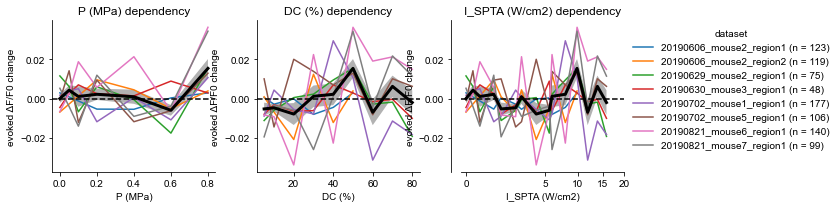

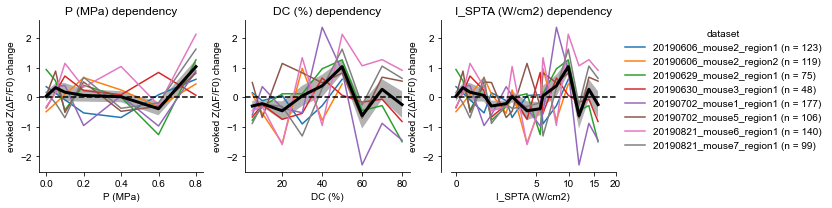

In [11]:
for ykey in [Label.DFF, Label.ZSCORE]:
    ykey_diff = get_change_key(ykey)
    figs[f'stimparamdeps {ykey_diff} initial'] = plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        avgprop='whue', 
        ci=None
    )

## Curations & corrections

### Identify and exclude datasets with no parameter dependency

In [12]:
# ykey_diff = get_change_key(Label.ZSCORE)

# # Compute population-average stats
# popagg_stats = get_popavg_data(ext_stats)

# # Assess response parameter dependency per dataset with ANOVA
# logger.info('assessing parameter dependence per dataset with ANOVA...')
# anovares = (
#     popagg_stats[ykey_diff]
#     .groupby(Label.DATASET)
#     .agg(lambda s: compute_1way_anova(s.reset_index(), Label.RUN, ykey_diff))
#     .rename('pval')
#     .to_frame()
# )
# anovares['sig'] = anovares['pval'] < PTHR_DETECTION
# nonpdeps_datasets = anovares[~anovares['sig']].index.values.tolist()
# if len(nonpdeps_datasets) > 0:
#     logger.warning(f'datasets with no parameter dependency:\n{pprint.pformat(nonpdeps_datasets)}')

# # Create figure backbone
# figs['pdep anova analysis'], axes = plt.subplots(1, 2, figsize=(8, 4))
# for ax in axes:
#     sns.despine(ax=ax)

# # Plot p-value distributions
# sns.histplot(
#     ax=axes[0],
#     data=anovares,
#     x='pval',
#     binwidth=.05,
#     hue='sig',
#     palette={True: 'g', False: 'r'}
# )
# axes[0].set_xlim(0, 1)

# # Plot parameter dependencies per dataset, along with ANOVA result color code
# sns.lineplot(
#     ax=axes[1],
#     data=popagg_stats,
#     x=Label.RUN,
#     y=ykey_diff,
#     hue=Label.DATASET,
#     palette=get_binary_palette(anovares, nonpdeps_datasets),
#     ci=None,
#     legend=False
# )
# axes[1].axhline(0, ls='--', c='k')

# if mouseline != 'pv':
#     # Exclude datasets with no parameter dependency, and re-plot param dependency curves
#     trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
#         trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, 
#         to_exclude=nonpdeps_datasets
#     )
#     for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
#         figs[f'stimparamdeps {ykey_diff} post anova exclude'] = plot_stimparams_dependency(
#             trialagg_stats.copy(),
#             xkeys=xkeys_plt,
#             ykey=ykey_diff, 
#             hue=Label.DATASET,
#             avgprop='whue', 
#             ci=None,
#         )

### Identify and remove datasets with outlier evoked z-score for P = 0

In [13]:
# ykey_diff = get_change_key(Label.ZSCORE)

# # Compute population-average stats per datasets for baseline run
# popagg_trialagg_stats = get_popavg_data(trialagg_stats)
# popagg_trialagg_stats0 = popagg_trialagg_stats[popagg_trialagg_stats[Label.P] == 0].droplevel(Label.RUN)
# # Identify datasets with outlier evoked z-scores (in any direction)
# zthr = pvalue_to_zscore(PTHR_DETECTION)
# is_P0_outlier = popagg_trialagg_stats0[ykey_diff].abs() > zthr
# P0_outlier_datasets = is_P0_outlier[is_P0_outlier].index.values.tolist()

# if len(P0_outlier_datasets) > 0:
#     P0_outliers_str = '\n'.join([f'  - {x}' for x in P0_outlier_datasets])
#     logger.warning(f'datasets with outlier response to P = 0 condition:\n{pprint.pformat(P0_outlier_datasets)}')

# # Plot parameter dependencies per dataset, along with ANOVA result color code
# figs['P0 zscore outlier detection'], ax = plt.subplots()
# sns.despine(ax=ax)
# fg = sns.lineplot(
#     ax=ax,
#     data=popagg_trialagg_stats,
#     x=Label.P,
#     y=ykey_diff,
#     hue=Label.DATASET,
#     palette=get_binary_palette(popagg_trialagg_stats, P0_outlier_datasets),
#     ci=None,
#     legend=False,
# )
# ax.axhline(0, ls='--', c='k')
# ax.axhspan(-zthr, zthr, fc='silver', ec=None, alpha=0.3)

# # Exclude datasets with no parameter dependency, and re-plot param dependency curves
# trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
#     trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, 
#     to_exclude=P0_outlier_datasets
# )

# for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
#     figs[f'stimparamdeps {ykey_diff} post P0 exclude'] = plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.DATASET,
#         avgprop='whue', 
#         ci=None,
#     )

### Inspect & correct response stationarity throughout trial sequences

 30/06/2023 18:39:32: computing population average data across (dataset, run, trial)...
 30/06/2023 18:39:32: comparing evoked ΔF/F0 change values in across half sequences...


0it [00:00, ?it/s]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 1.00e-01
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_1 vs. 9_2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.441e-02 U_stat=1.932e+03
10_1 vs. 10_2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.614e-01 U_stat=1.121e+03
11_1 vs. 11_2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.204e-01 U_stat=1.506e+03
12_1 vs. 12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.165e-01 U_stat=1.403e+03
13_1 vs. 13_2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.052e-01 U_stat=1.453e+03
14_1 vs. 14_2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.672e-01 U_stat=1.341e+03
15_1 vs. 15_2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.634e-01 U_stat=3.500e+01
8_1 vs. 8_2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.416e-01 U_stat=1.644e+03
1_1 vs. 1_2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.229e-01 U_stat=1.653e+03
0_1 vs. 0_2: Mann-Whitney-Wilcoxon test two-sided, 

1it [00:00,  1.95it/s]

7_1 vs. 7_2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.405e+03
 30/06/2023 18:39:33: plotting evoked ΔF/F0 change along trial sequences...


 30/06/2023 18:39:37: computing ROI-weighted average of (8 datasets x 357 ROIs x 15 runs x 16 trials) "evoked ΔF/F0 change" series across run ID & trial...
 30/06/2023 18:39:38: adding regression estimates...
 30/06/2023 18:39:40: assessing evoked ΔF/F0 change stationarity, by run ID, with linear regression analysis
 30/06/2023 18:39:40: no significant evoked ΔF/F0 change non-stationarity identified


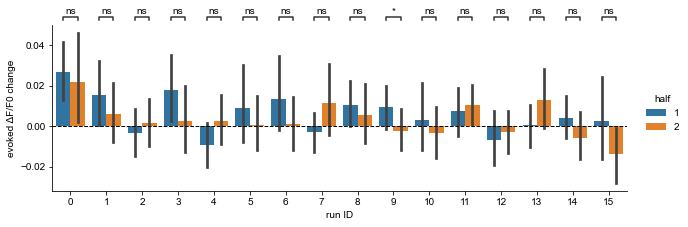

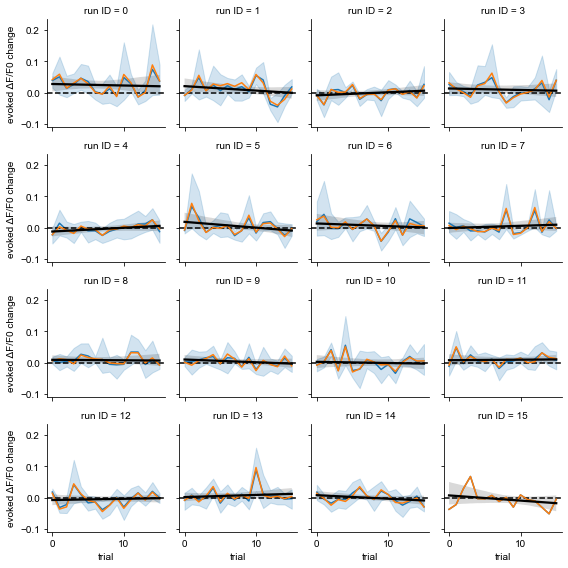

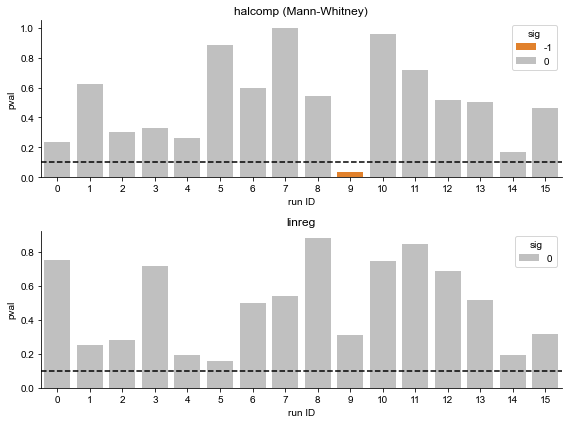

In [14]:
from constants import PTHR_STATIONARITY

# Determine output metrics
ykey_diff = get_change_key(Label.DFF)
stationarity_gby = Label.RUNID  # grouping variable for stationarity analysis

# Compute population-average stats for each trial 
popagg_stats = get_popavg_data(ext_stats)

# Add trial half information
isplit = len(popagg_stats.index.unique(Label.TRIAL)) // 2 - 1
popagg_stats['half'] = popagg_stats.index.get_level_values(Label.TRIAL) <= isplit
popagg_stats['half'] = popagg_stats['half'].map({True: 1, False: 2})

# Evaluate difference between each half distribution statistically
logger.info(f'comparing {ykey_diff} values in across half sequences...')
from scipy.stats import mannwhitneyu, ttest_ind
testtype = 'Mann-Whitney'
# testtype = 't-test_ind'
testfunc = {
    't-test_ind': ttest_ind,
    'Mann-Whitney': mannwhitneyu
}[testtype]
cross_dataset_halfcomp_stats = (
    popagg_stats
    .groupby(stationarity_gby)
    .apply(lambda df: compare_halves(df, ykey_diff, testfunc))
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='diff'))
)

# Plot halves comparison results
pltkwargs = dict(
    data=popagg_stats.reset_index(),
    x=stationarity_gby,
    y=ykey_diff,
    hue='half',
)
fg = sns.catplot(
    kind='bar',
    aspect=3,
    height=3,
    **pltkwargs)
fg.refline(y=0, c='k', lw=1)
annotate_facets(fg, test=testtype, alpha=PTHR_STATIONARITY, **pltkwargs)

# Plot response strength over trial sequence, by grouping variable, 
# with superimposed linear regression estimate
logger.info(f'plotting {ykey_diff} along trial sequences...')
trialseq_fgkwargs = dict(
    x=Label.TRIAL,
    y=ykey_diff,
    col_wrap=4,
    height=2.,
    legend='full'
)
fg = sns.relplot(
    kind='line',
    data=popagg_stats,
    col=stationarity_gby,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')
weighted_popagg_stats = get_crossdataset_average(
    ext_stats, [stationarity_gby, Label.TRIAL], ykey=ykey_diff)
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata[f'{ykey_diff} - mean'], c='C1')
logger.info('adding regression estimates...')
fg.map_dataframe(
    sns.regplot, 
    scatter=False, 
    color='k', 
    x=Label.TRIAL, 
    y=ykey_diff,
)
figs[f'{ykey_diff} stationarity along trial seq'] = fg.figure

# Perform linear regression on lumped data, by grouping variable, to assess response stationarity
logger.info(f'assessing {ykey_diff} stationarity, by {stationarity_gby}, with linear regression analysis')
cross_dataset_linreg_stats = (popagg_stats
    .groupby(stationarity_gby)
    [ykey_diff]
    .apply(apply_linregress)
    .unstack()
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='slope'))
)

# Plot stationarity p-value for each group
stationarity_measures = {
    f'halcomp ({testtype})': cross_dataset_halfcomp_stats,
    'linreg': cross_dataset_linreg_stats
}
figs[f'{ykey_diff} stationarity p-value by {stationarity_gby}'], axes = plt.subplots(2, 1, figsize=(8, 6))
for ax, (k, resdata) in zip(axes, stationarity_measures.items()):
    sns.despine(ax=ax)
    sns.barplot(
        ax=ax,
        data=resdata.reset_index(),
        x=stationarity_gby,
        y='pval',
        hue='sig',
        palette=Palette.TERNARY,
        dodge=False,
    )
    ax.set_title(k)
    ax.axhline(PTHR_STATIONARITY, ls='--', c='k')
figs[f'{ykey_diff} stationarity p-value by {stationarity_gby}'].tight_layout()

# Identify and mark groups with non-stationarity in response strength
non_stationary_groups = cross_dataset_linreg_stats[cross_dataset_linreg_stats['sig'] != 0].index.values
if len(non_stationary_groups) > 0:
    logger.warning(f'identified {ykey_diff} non-stationarity in the following {stationarity_gby}: {non_stationary_groups}')
    for k in non_stationary_groups:
        fg.axes_dict[k].set_title(f'{fg.axes_dict[k].get_title()} *', fontsize=10)
else:
    logger.info(f'no significant {ykey_diff} non-stationarity identified')


# Trick: restrict non-stationary groups to first zero
if stationarity_gby == Label.RUNID:
    non_stationary_groups = list(set(non_stationary_groups).intersection([0]))

# For each non-stationary group
if do_nonstat_correct and len(non_stationary_groups) > 0:
    for group_id in non_stationary_groups:

        # Extract detailed stats for that group
        logger.info(f'extracting detailed stats for {stationarity_gby} {group_id}...')
        if stationarity_gby in ext_stats.index.names:
            detailed_stats_group = ext_stats[ext_stats.index.get_level_values(stationarity_gby) == group_id]
        else:
            detailed_stats_group = ext_stats[ext_stats[stationarity_gby] == group_id]

        # Extract last trial index for each ROI
        logger.info('extracting last trial index for each ROI...')
        last_trial_idx = (detailed_stats_group.iloc[:, 0]
            .groupby([Label.DATASET, Label.ROI, Label.RUN])
            .agg(lambda s: s.index[-1][-1])
        )

        # Perform independent linear regression for each ROI, over trial sequence
        logger.info(f'performing {ykey_diff} linear regression independently on each ROI...')
        linreg_stats_per_roi = (detailed_stats_group[ykey_diff]
            .groupby([Label.DATASET, Label.ROI, Label.RUN])
            .apply(apply_linregress)
            .unstack()
        )

        # Compute project response at last trial from linear regression results
        logger.info(f'projecting {ykey_diff} values from linear regression results...')
        ydiff_proj = linreg_stats_per_roi['slope'] * last_trial_idx + linreg_stats_per_roi['intercept']

        # Compute ratios between trial-aggregated and projected responses
        logger.info(f'computing ratios between trialagg {ykey_diff} values and their lin-reg projected values...')
        ratios = ydiff_proj / trialagg_stats.loc[ydiff_proj.index, ykey_diff]

        # Replace trial-aggregated response values by projected responses values 
        logger.info(f'replacing trialagg {ykey_diff} values by their lin-reg projected values...')
        trialagg_stats.loc[ydiff_proj.index, ykey_diff] = ydiff_proj

        # Use computed ratios to rescale z-scores as well
        zkey_diff = get_change_key(Label.ZSCORE)
        logger.info(f're-scaling trialagg {zkey_diff} values according to {ykey_diff} ratios...')
        trialagg_stats.loc[ydiff_proj.index, zkey_diff] *= ratios
    
        # Re-assess responses
        zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
        trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
            trialagg_stats[get_change_key(Label.ZSCORE)], zthr, directional=directional)
    
    # Re-classify responders
    roistats = classify_ROIs(trialagg_stats)
    for k in roistats:
        trialagg_stats[k] = roistats[k]

    # Re-plot parameter dependency curves
    for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
        figs[f'{ykey_diff} stimparamdeps post global stationary correct'] = plot_stimparams_dependency(
            trialagg_stats.copy(),
            xkeys=xkeys_plt,
            ykey=ykey_diff, 
            hue=Label.DATASET,
            avgprop='whue',
            ci=None,
        )
    
    do_nonstat_correct = False

## Results visualization

### Plot evoked change distribution for control condition (P = 0)

 30/06/2023 18:39:41: response type proportions at P = 0:
weak        92.099323
positive     7.900677
Name: response type, dtype: float64


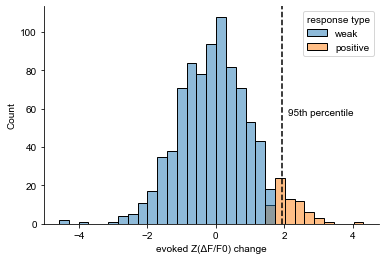

In [15]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Plot parameter dependency curves

 30/06/2023 18:39:41: plotting ΔF/F0 stimulation parameters dependencies...
 30/06/2023 18:39:41: sub-indexing data...
 30/06/2023 18:39:41: filtering data...
 30/06/2023 18:39:41: cross-checking filters...
 30/06/2023 18:39:41: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 30/06/2023 18:39:41: estimating initial fit parameters for sigmoid function
 30/06/2023 18:39:41: fitting results: popt = [0.80214822 0.00894973 0.03493024], R2 = 0.76
 30/06/2023 18:39:41: sub-indexing data...
 30/06/2023 18:39:41: filtering data...
 30/06/2023 18:39:41: cross-checking filters...
 30/06/2023 18:39:41: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 30/06/2023 18:39:41: estimating initial fit parameters for sigmoid function
 30/06/2023 18:39:41: fitting results: popt = [ 2.56261912e+01 -1.14952345e-01 -5.88940290e-03], R2 = 0.23
 30/06/2023 18:39:41: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 1

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


 30/06/2023 18:39:41: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. DC (%) ...
 30/06/2023 18:39:41: estimating initial fit parameters for sigmoid function
 30/06/2023 18:39:41: fitting results: popt = [26.01789312 -0.1268588  -0.32789457], R2 = 0.15
 30/06/2023 18:39:41: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:39:41: sub-indexing data...
 30/06/2023 18:39:41: filtering data...
 30/06/2023 18:39:41: cross-checking filters...
 30/06/2023 18:39:41: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) ...
 30/06/2023 18:39:41: estimating initial fit parameters for sigmoid function
 30/06/2023 18:39:41: fitting results: popt = [-8.37572402e+01 -8.22457707e+00  1.46488007e-02], R2 = -0.00
 30/06/2023 18:39:41: estimating initial fit parameters for sigmoid function
 30/06/2023 18:39:41: fitting results: popt = [5.92973478e+00 4.37996010e-01 3.52073916e+04], R2 = 0.56
 30/06/2023 18:39:41: 

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


 30/06/2023 18:39:42: estimating initial fit parameters for sigmoid function
 30/06/2023 18:39:42: fitting results: popt = [3.03880584 3.566232   0.2029843 ], R2 = 0.36


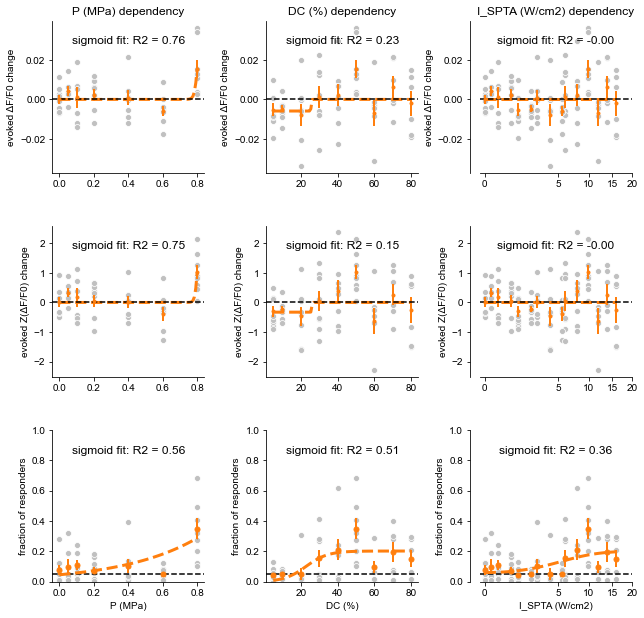

In [16]:
from utils import get_sigmoid_params
figs['stimparamdeps post curation'] = plot_all_deps(
    trialagg_stats, 
    xkeys_plt,  
    ykeys_plt,
    palette='uniform',
    avg_color='line',
    marker='o', lw=0,
    err_style='bars',
    height=3,
    fit=(sigmoid, get_sigmoid_params)
)

### ROI breakdown per dataset

 30/06/2023 18:39:42: computing fraction of response occurence per ROI over 9 "strong ISPTA" conditions...
 30/06/2023 18:39:42: identified 4.4% of responders with 0.5 as threshold proportion of responding conditions
 30/06/2023 18:39:42: plotting cell maps...


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


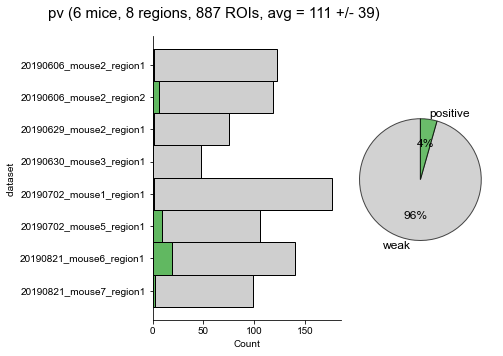

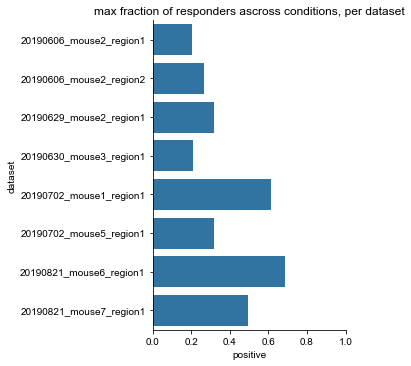

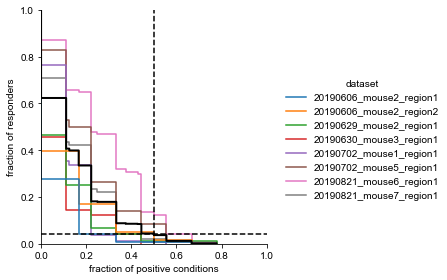

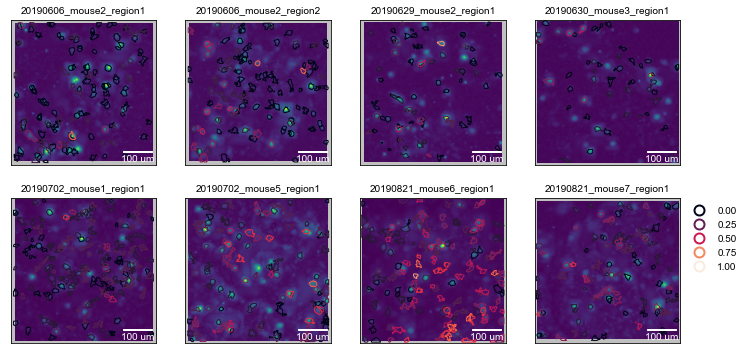

In [17]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour', hue='positive')

 30/06/2023 18:39:46: dataset: 20190606_mouse2_region1
 30/06/2023 18:39:46: Computing average response scores over 6-by-6 grid
 30/06/2023 18:39:46: applying cubic interpolation over 256-by-256 evaluation grid
 30/06/2023 18:39:46: dataset: 20190606_mouse2_region2
 30/06/2023 18:39:46: Computing average response scores over 6-by-6 grid
 30/06/2023 18:39:46: defining unstructured cubic interpolator from 24/25 grid points
 30/06/2023 18:39:46: applying interpolator over 256-by-256 evaluation grid
 30/06/2023 18:39:46: dataset: 20190629_mouse2_region1
 30/06/2023 18:39:46: Computing average response scores over 6-by-6 grid
 30/06/2023 18:39:46: defining unstructured cubic interpolator from 23/25 grid points
 30/06/2023 18:39:46: applying interpolator over 256-by-256 evaluation grid
 30/06/2023 18:39:46: dataset: 20190630_mouse3_region1
 30/06/2023 18:39:46: Computing average response scores over 6-by-6 grid
 30/06/2023 18:39:46: defining unstructured cubic interpolator from 19/25 grid po

/Users/tlemaire/Documents/code/usnm2p/plotters.py:1910: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1910: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1910: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1910: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1910: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, z.T, levels=levels, colors='k')
/Users/tlemaire/Documents/code/usnm2p/plotters.py:1910: UserWarning: No contour levels were found within the data range.
  ax.contour(x, y, 

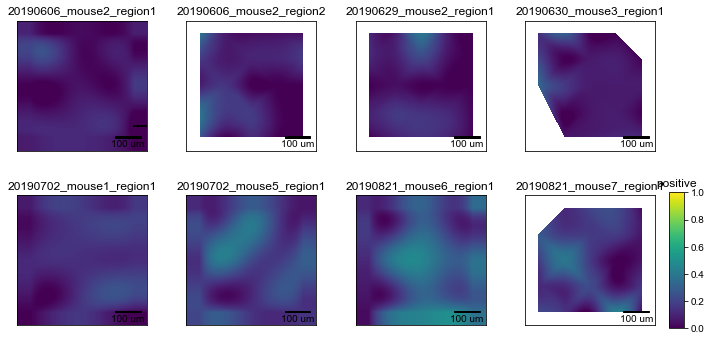

In [18]:
figs['response maps']= plot_response_map(
    ROI_masks, trialagg_stats, map_ops, 
    fs=12,
    interp_method='cubic',
    # mark_ROIs=True
)

### Plot ROI / neuropil fluorescence ratio

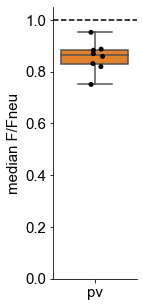

In [19]:
from plotters import plot_fluorescence_ratios
figs['F/Fneu'] = plot_fluorescence_ratios(popagg_timeseries, mouseline)

### Inspect dynamics of population-averaged activity

 30/06/2023 18:39:47: adding time info to table...
 30/06/2023 18:39:47: adding phase info to table...
 30/06/2023 18:39:47: inter-sonication interval = 27.81 s, i.e. trial repetition frequency = 0.04 Hz


8it [00:01,  4.16it/s]


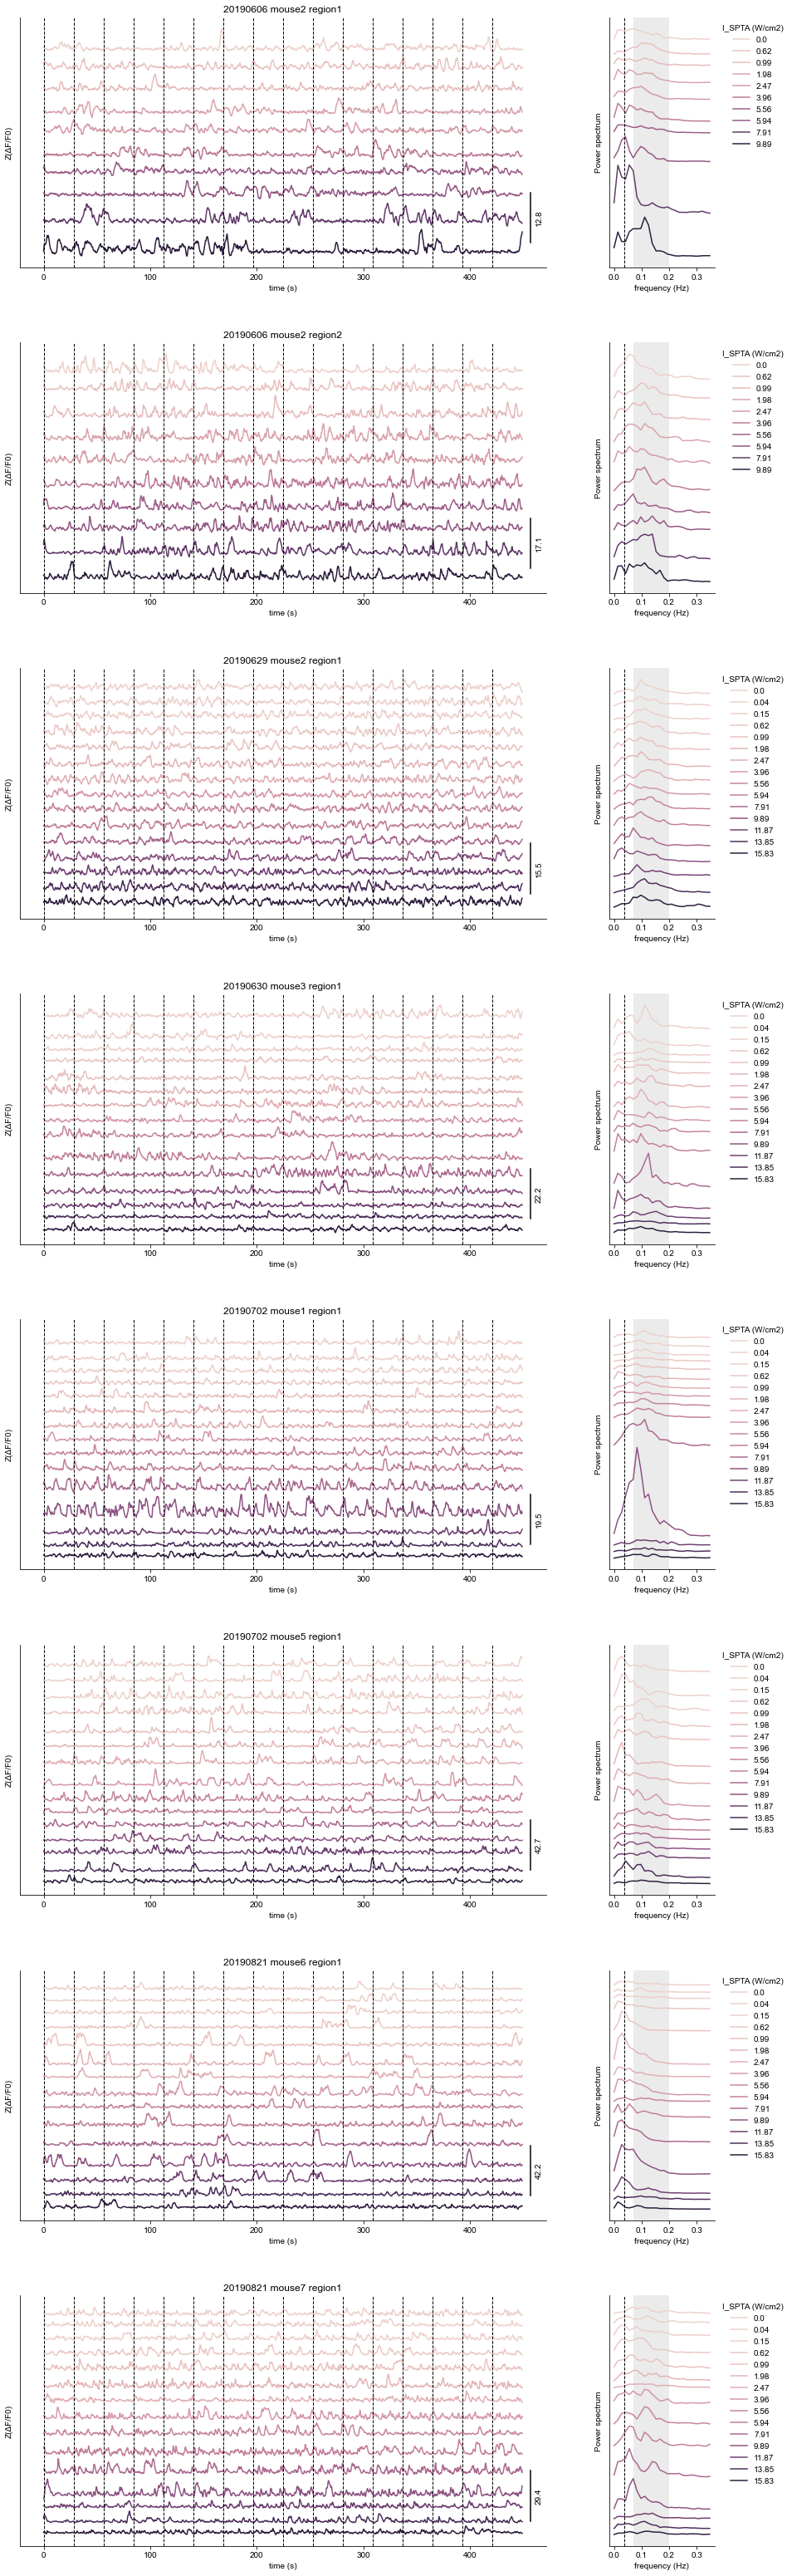

In [20]:
# Define output metrics
ykey = Label.ZSCORE

# Extract frame rate
fps = get_singleton(trialagg_stats, Label.FPS)

# Add time, trial phase, run ID and ISPTA info to popagg_timeseries
add_time_to_table(popagg_timeseries, fps=fps)
add_trial_phase_to_table(popagg_timeseries)
popagg_params_by_run = popagg_stats.groupby([Label.DATASET, Label.RUN]).first()
popagg_timeseries[Label.RUNID] = popagg_params_by_run[Label.RUNID]
popagg_timeseries[Label.ISPTA] = popagg_params_by_run[Label.ISPTA].round(2)

# Extract trial-repetition frequency
ISI = (NFRAMES_PER_TRIAL - 1) / fps  # inter-sonication interval
ftrial = 1 / ISI
logger.info(f'inter-sonication interval = {ISI:.2f} s, i.e. trial repetition frequency = {ftrial:.2f} Hz')

# Extract response window interval
resp_tbounds = (bounds(FrameIndex.RESPONSE) - FrameIndex.STIM) / fps

# Define plotting options
fmax = .35  # upper frequency limit for spectrum graphs

# Define frequency band for neural oscillations of interest
fband_osc = [.07, .2]  # Hz

# Plot timecourses and frequency spectra across runs, for population-average data
ykeys = [ykey]
nrows = popagg_timeseries.groupby(Label.DATASET).ngroups
figs[f'popagg {ykey} metrics'], axes = plt.subplots(
    nrows, 2, figsize=(15, 7 * nrows), 
    gridspec_kw=dict(width_ratios=(1, .2))
)
hue = Label.ISPTA
groups = popagg_timeseries.groupby(Label.DATASET)
logger.setLevel(logging.WARNING)
for axrow, (dadaset_id, gdata) in tqdm(zip(axes, groups)):
    mydata = gdata.reset_index(level=Label.DATASET, drop=True)
    plot_popagg_timecourse(
        mydata, ykeys, fps, ax=axrow[0], legend=False, hue=hue)
    plot_popagg_frequency_spectrum(
        mydata, ykeys, fps, fmax=fmax, ax=axrow[1], fband=fband_osc, hue=hue)
    sns.move_legend(axrow[1], 'upper left', bbox_to_anchor=(1, 1), frameon=False)
    axrow[0].set_title(dadaset_id.replace('_', ' '))
logger.setLevel(logging.INFO)
figs[f'popagg {ykey} metrics'].subplots_adjust(hspace=0.3)

### Inpsect parameter dependency of amplitude of neural oscillations

 30/06/2023 18:39:51: computing linear regression of frequency spectrum amplitude within oscillation band on Ispta
 30/06/2023 18:39:51: pvalue = 0.695


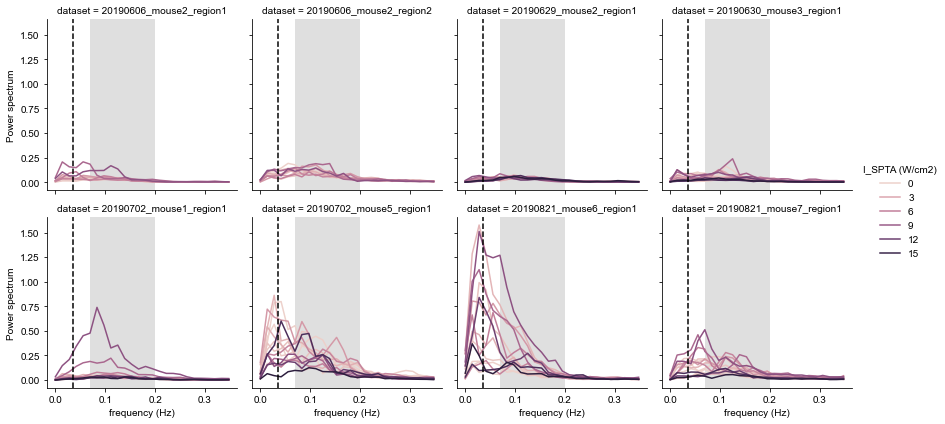

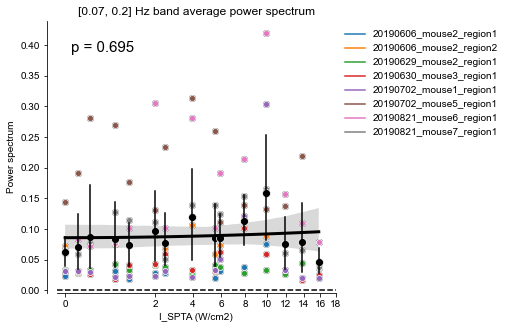

In [21]:
# Extract power spectrum for each dataset and Ispta
hue = Label.ISPTA
popagg_spectra = (popagg_timeseries
    .reset_index()
    .groupby([Label.DATASET, hue])
    [ykey]
    .apply(lambda s: get_power_spectrum(s, fps))
)
popagg_spectra = popagg_spectra[popagg_spectra[Label.FREQ] <= fmax]

# Plot power spectra for each dataset and run
fg = sns.relplot(
    kind='line',
    data=popagg_spectra,
    x=Label.FREQ,
    y=Label.PSPECTRUM,
    col=Label.DATASET,
    hue=hue,
    col_wrap=4,
    ci=None,
    height=3,
)
for ax in fg.axes.ravel():
    ax.axvspan(*fband_osc, fc='silver', ec=None, alpha=.5)
    ax.axvline(ftrial, c='k', ls='--')

# Extract power spectrum over oscillation band of interest
osc_spectra = popagg_spectra[popagg_spectra[Label.FREQ].between(*fband_osc)][
    Label.PSPECTRUM].groupby([Label.DATASET, hue]).mean().to_frame()

# Compute linear regression of oscillation spectrum amplitude on Ispta and assess wether it is significant
logger.info('computing linear regression of frequency spectrum amplitude within oscillation band on Ispta')
osc_spectra_reg = apply_linregress(osc_spectra, xkey=Label.ISPTA, ykey=Label.PSPECTRUM)
logger.info(f'pvalue = {osc_spectra_reg.pval:.3g}')

figs['osc power vs. ispta'], ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax)
for hue in [Label.DATASET, None]:
    sns.lineplot(
        ax=ax,
        data=osc_spectra,
        x=Label.ISPTA,
        y=Label.PSPECTRUM,
        color='k' if hue is None else None,
        lw=0,
        marker='o',
        markersize=8 if hue is None else 6,
        hue=hue,
        err_style='bars',
    )

# Plot linear regression line
sns.regplot(
    ax=ax,
    data=osc_spectra.reset_index(),
    x=Label.ISPTA,
    y=Label.PSPECTRUM,
    color='k',
    line_kws=dict(lw=3),
)

# Adjust x-scale
adjust_xscale(ax, xscale='sqrt')

# Add significance level
ax.text(
    .05, .9, f'p = {osc_spectra_reg.pval:.3g}', transform=ax.transAxes, 
    ha='left', va='center', fontsize=15)

ax.set_title(f'{fband_osc} Hz band average power spectrum')
ax.axhline(0, ls='--', c='k')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

### Extract oscillation envelope and instantaneous phase

 30/06/2023 18:39:52: computing hilbert transform attributes of population-average timecourses
 30/06/2023 18:39:52: unwrapping extracted phase profiles
 30/06/2023 18:39:52: plotting population-average timecourses and phase profiles


8it [00:03,  2.17it/s]


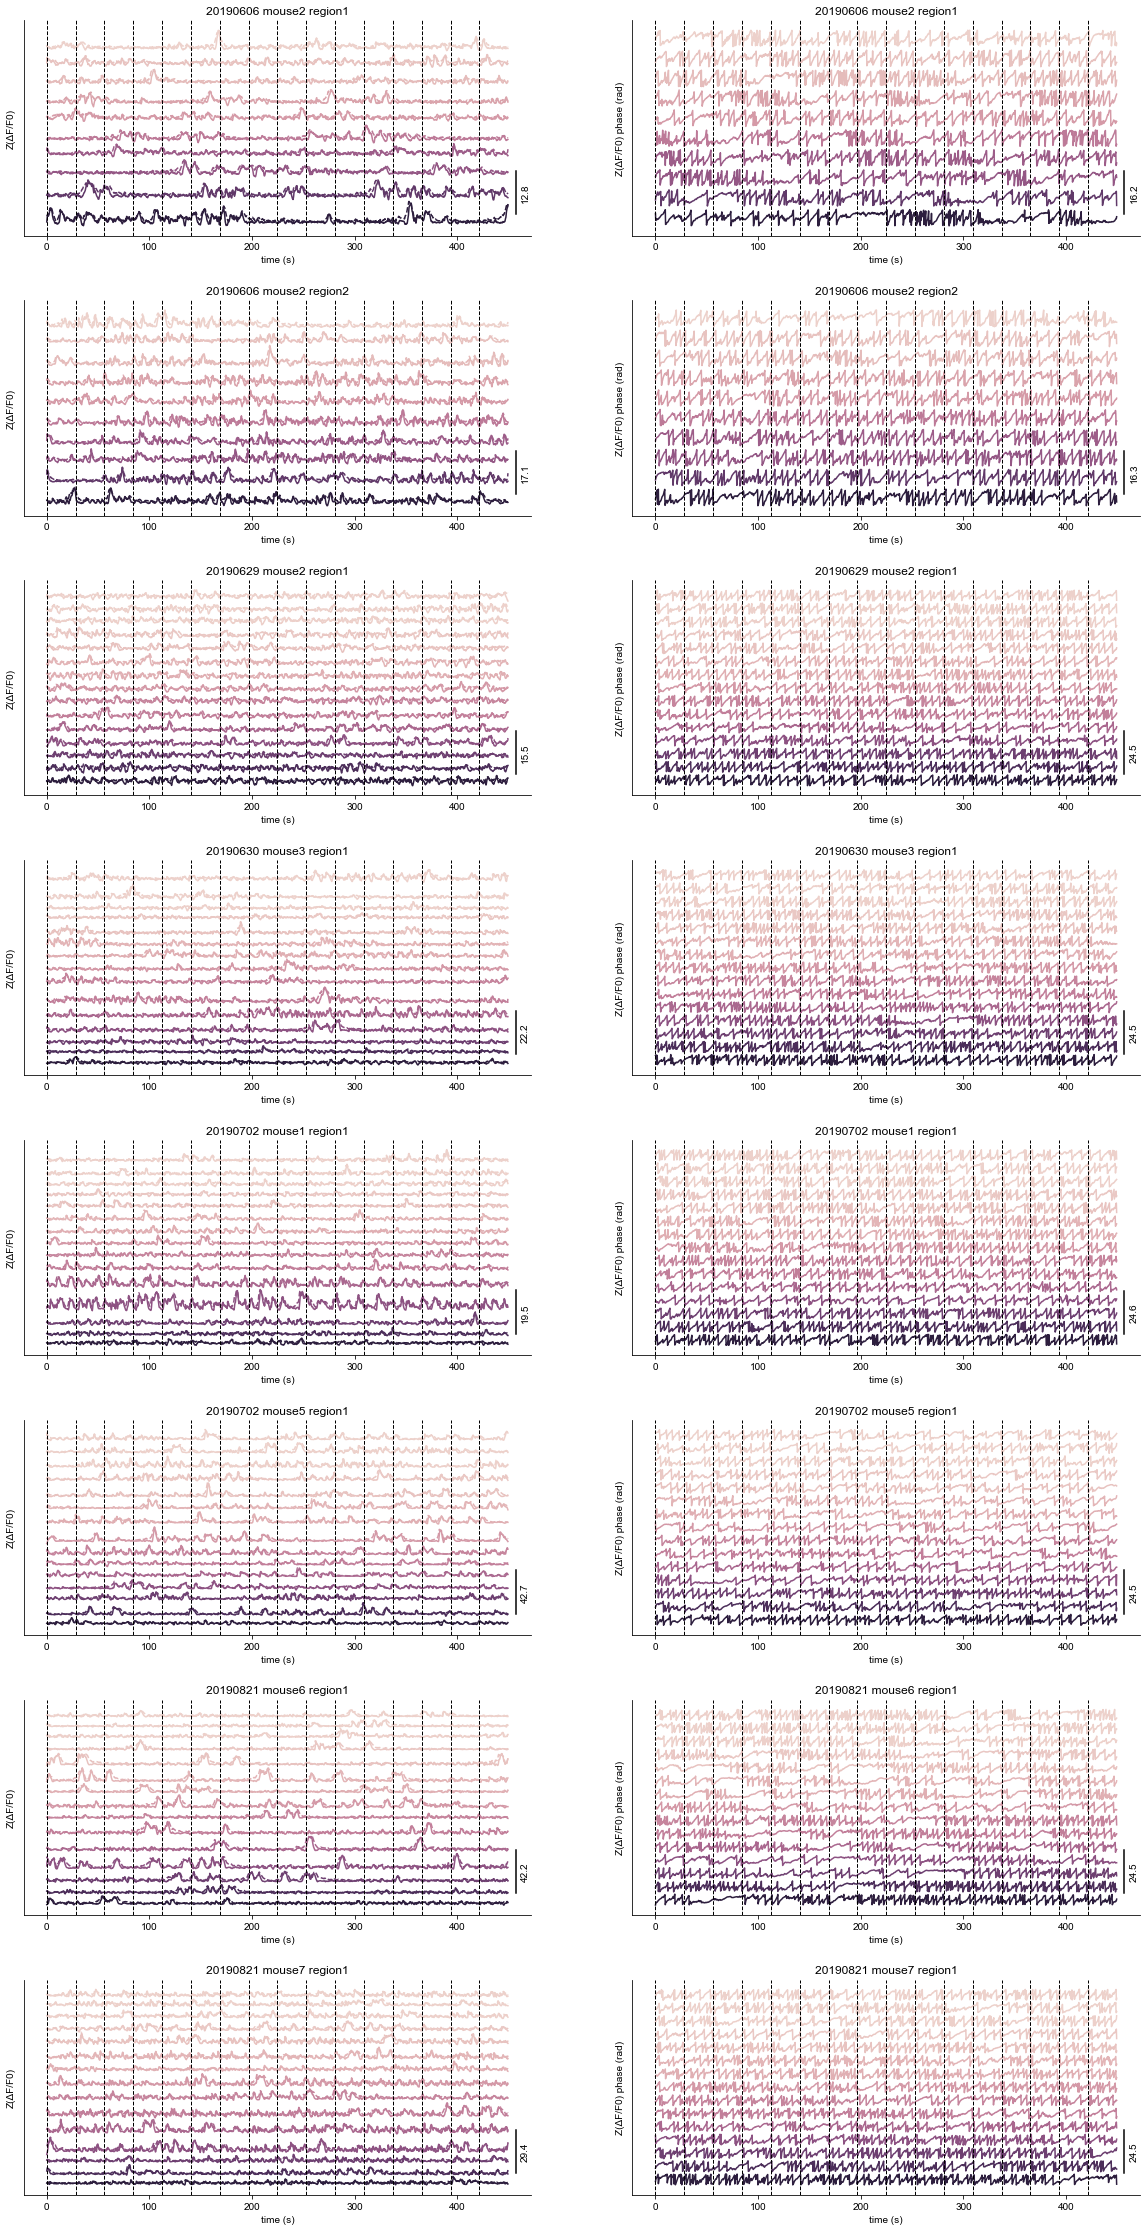

In [22]:
# Extract signal envelope and instantaneous phase
logger.info('computing hilbert transform attributes of population-average timecourses')
hilbert_info = (popagg_timeseries[ykey].groupby(
    [Label.DATASET, Label.RUN]).apply(extract_hilbert)
    .add_prefix(f'{ykey} ')
)
for k in hilbert_info:
    popagg_timeseries[k] = hilbert_info[k]

# Define keys for phase and envelope
phasekey = f'{ykey} {Label.PHASE}'
envkey = f'{ykey} {Label.ENV}'

# Unwrap phase and save it as a new column
logger.info('unwrapping extracted phase profiles')
unwrapped_phasekey = f'unwrapped {ykey} {Label.PHASE}'
popagg_timeseries[unwrapped_phasekey] = popagg_timeseries[phasekey].groupby(
    [Label.DATASET, Label.RUN]).transform(np.unwrap)

# Create figure
logger.info('plotting population-average timecourses and phase profiles')
nrows = popagg_timeseries.groupby(Label.DATASET).ngroups
figs[f'popagg {ykey} hilbert'], axes = plt.subplots(
    nrows, 2, figsize=(20, 5 * nrows))
groups = popagg_timeseries.groupby(Label.DATASET)

# Loop over datasets
logger.setLevel(logging.WARNING)
hue = Label.ISPTA
for axrow, (dadaset_id, gdata) in tqdm(zip(axes, groups)):
    mydata = gdata.reset_index(level=Label.DATASET, drop=True)

    # Left side: plot envelope profiles overlaid on signal timecourses 
    plot_popagg_timecourse(
        mydata, [ykey, f'{ykey} {Label.ENV}'], fps, ax=axrow[0], legend=False, hue=hue)

    # Right side: plot instantaneous phase profiles 
    plot_popagg_timecourse(
        mydata, f'{ykey} {Label.PHASE}', fps, ax=axrow[1], legend=False, hue=hue)

    axrow[0].set_title(dadaset_id.replace('_', ' '))
    axrow[1].set_title(dadaset_id.replace('_', ' '))
logger.setLevel(logging.INFO)
figs[f'popagg {ykey} hilbert'].subplots_adjust(hspace=0.3)

### Inspect phase variation & synchronization across the trial interval 

 30/06/2023 18:39:57: computing Z(ΔF/F0) phase derivative
 30/06/2023 18:39:57: computing Z(ΔF/F0) phase-locking factor
 30/06/2023 18:39:57: adding time info to table...
 30/06/2023 18:39:58: plotting


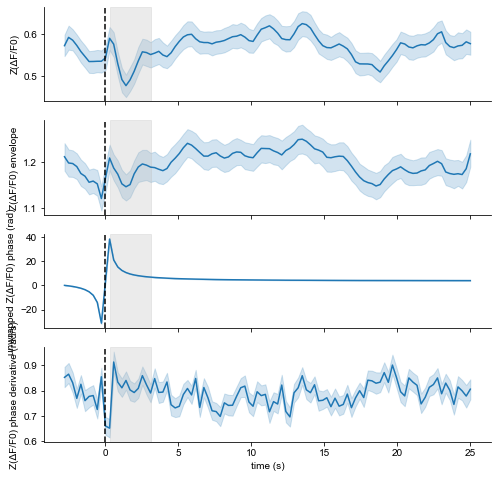

In [23]:
# Get phase derivative from unwrapped phase
logger.info(f'computing {ykey} phase derivative')
dphasekey = f'{ykey} phase derivative (rad/s)'
popagg_timeseries[dphasekey] = (popagg_timeseries[unwrapped_phasekey]
    .groupby([Label.DATASET, Label.RUN])
    .transform(lambda s: s.diff().shift(1) * fps)
)

# Compute phase-locking factor (PLF) from phase timecourse
logger.info(f'computing {ykey} phase-locking factor')
# Compute complex exponential of phase timecourse for each dataset and run
theta = popagg_timeseries[phasekey].groupby([Label.DATASET, Label.RUN]).apply(complex_exponential)
# For each dataset and run, average across trials and extract modulus
plf = theta.groupby([Label.DATASET, Label.RUN, Label.FRAME]).mean().abs().rename('PLF').to_frame()
# Add time and run params info to plf table
add_time_to_table(plf, fps=fps)
for k in get_params_by_run(popagg_stats):
    plf[k] = popagg_stats[k].groupby([Label.DATASET, Label.RUN]).first()

# Reset phase to zero on every trial start
tmp = popagg_timeseries.copy()
tmp[unwrapped_phasekey] = tmp[unwrapped_phasekey].groupby(
    [Label.DATASET, Label.RUN, Label.TRIAL]).transform(lambda s: s - s.iloc[0])
tmp[unwrapped_phasekey] = tmp[unwrapped_phasekey] / tmp[Label.TRIALPHASE]

# Plot average phase and phase derivative profiles
logger.info('plotting')
hue = None #Label.ISPTA
ykeys = [ykey, envkey, unwrapped_phasekey, dphasekey]# , 'PLF']
figs['phase var & sync'], axes = plt.subplots(len(ykeys), 1, figsize=(8, 2 * len(ykeys)), sharex=True)
for ax, yk in zip(axes, ykeys):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=plf if yk == 'PLF' else tmp,
        x=Label.TIME,
        y=yk,
        hue=hue,
        ci=CI if hue is None else None,
        legend=yk == ykeys[0],
    )
    ax.axvline(0, ls='--', c='k')
    ax.axvspan(*resp_tbounds, color='silver', alpha=.3)
    if yk == ykeys[0] and hue is not None:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

### Evaluate parameter-dependency of phase locking

 30/06/2023 18:40:11: computing evoked PLF
 30/06/2023 18:40:11: computing linear regression of evoked PLF on Ispta
 30/06/2023 18:40:11: pvalue = 0.000144
 30/06/2023 18:40:11: plotting evoked PLF vs Ispta


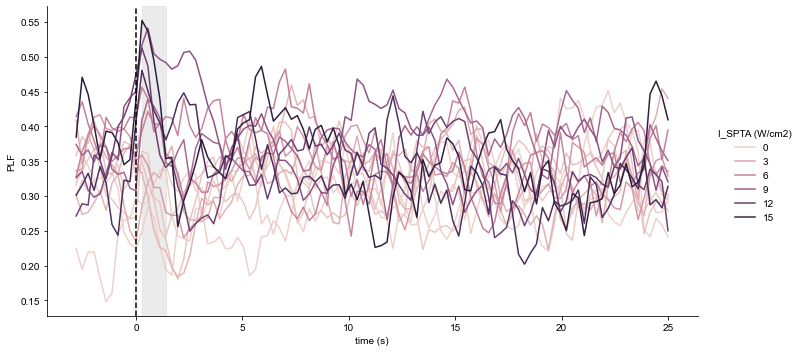

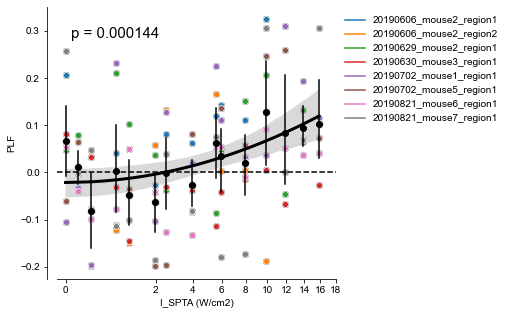

In [24]:
# Extract short response window interval
shortresp_tbounds = (bounds(FrameIndex.RESPSHORT) - FrameIndex.STIM) / fps

# Plot PLF profile vs Ispta
fg = sns.relplot(
    kind='line',
    data=plf,
    x=Label.TIME,
    y='PLF',
    # col=Label.DATASET,
    # col_wrap=2,
    hue=Label.ISPTA,
    ci=None,
    aspect=2
)
fg.refline(x=0, ls='--', c='k')
for ax in fg.axes.ravel():
    ax.axvspan(*shortresp_tbounds, color='silver', alpha=.3)
figs['PLF trace vs Ispta'] = fg.figure

# Compute evoked PLF for each dataset and run
logger.info('computing evoked PLF')
baseline_plf = plf['PLF'].groupby([Label.DATASET, Label.RUN]).median()
post_plf = plf.loc[pd.IndexSlice[:, :, FrameIndex.RESPSHORT], 'PLF'].groupby(
    [Label.DATASET, Label.RUN]).mean()
evoked_plf = (post_plf - baseline_plf).to_frame()

# Add run parameters to evoked PLF table
runparams = get_params_by_run(popagg_stats)
for k in runparams:
    evoked_plf[k] = popagg_stats[k].groupby([Label.DATASET, Label.RUN]).first()

# Compute linear regression of evoked PLF on Ispta and assess wether it is significant
logger.info('computing linear regression of evoked PLF on Ispta')
evoked_plf_reg = apply_linregress(evoked_plf, xkey=Label.ISPTA, ykey='PLF')
logger.info(f'pvalue = {evoked_plf_reg.pval:.3g}')

# Plot evoked PLF vs run parameters
logger.info('plotting evoked PLF vs Ispta')
figs['PLF vs Ispta'], ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax)
for hue in [Label.DATASET, None]:
    sns.lineplot(
        ax=ax,
        data=evoked_plf,
        x=Label.ISPTA, 
        y='PLF',
        color='k' if hue is None else None,
        lw=0,
        marker='o',
        markersize=8 if hue is None else 6,
        hue=hue,
        err_style='bars',
    )

# Add linear regression line
sns.regplot(
    ax=ax,
    data=evoked_plf,
    x=Label.ISPTA,
    y='PLF',
    color='k',
    line_kws=dict(lw=3),
)

# Add significance level
ax.text(
    .05, .9, f'p = {evoked_plf_reg.pval:.3g}', transform=ax.transAxes, 
    ha='left', va='center', fontsize=15)

adjust_xscale(ax, 'sqrt')

# Add zero line and move legend
ax.axhline(0, ls='--', c='k')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

### Inspect impact of phase at stimulus onset on evoked change in phase 

 30/06/2023 18:40:11: plotting phase derivative vs phase at stimulus onset


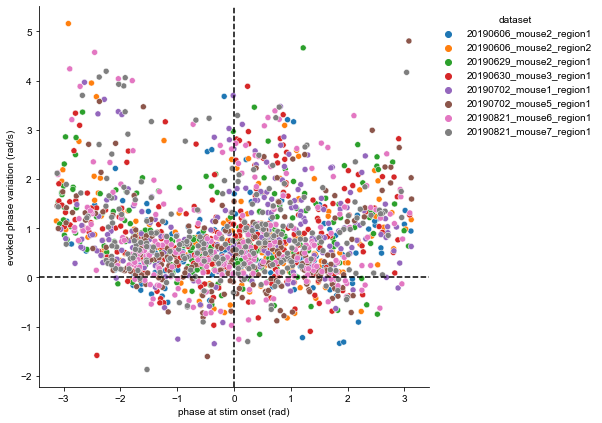

In [25]:
from constants import FrameIndex
# Get phase value at stimulus onset
stimonset_phi = popagg_timeseries.loc[
    pd.IndexSlice[:, :, :, FrameIndex.STIM], phasekey].droplevel(Label.FRAME)
# Get phase difference induced by stimulus
evoked_dphi = popagg_timeseries.loc[
    pd.IndexSlice[:, :, :, FrameIndex.RESPSHORT], dphasekey].groupby(
    [Label.DATASET, Label.RUN, Label.TRIAL]).mean()
# Assemble into dataframe
stimphase_df = pd.concat([
    stimonset_phi.rename('phase at stim onset (rad)'),
    evoked_dphi.rename('evoked phase variation (rad/s)')
], axis=1)

# Plot evoked phase derivative vs phase at stimulus onset
logger.info('plotting phase derivative vs phase at stimulus onset')
figs['dphi vs phi'], ax = plt.subplots(figsize=(7, 7))
sns.despine(ax=ax)
sns.scatterplot(
    ax=ax,
    data=stimphase_df,
    x='phase at stim onset (rad)',
    y='evoked phase variation (rad/s)',
    hue=Label.DATASET,
)
ax.axhline(0, ls='--', c='k')
ax.axvline(0, ls='--', c='k')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

In [26]:
# # Define frequency band for neural oscillations of interest
# myfband = [.1, np.inf]  # Hz
# myfband_str = f'flow = {myfband[0]:.3f} Hz, fhigh = {myfband[1]:.3f} Hz'
# logger.info(f'optimal frequency band: {myfband_str}')

# # Define key for filtered data
# filtered_key = f'filtered {ykey}'

# # Filter out oscillations with optimized bandstop filter
# sos, filterfunc = get_butter_filter_func(fps, myfband, kind='pass')
# # popagg_timeseries[filtered_key] = (popagg_timeseries[ykey]
# #     .groupby([Label.DATASET, Label.RUN])
# #     .apply(filterfunc)
# # )

### Inspect trial-aggreated, pop-average activity

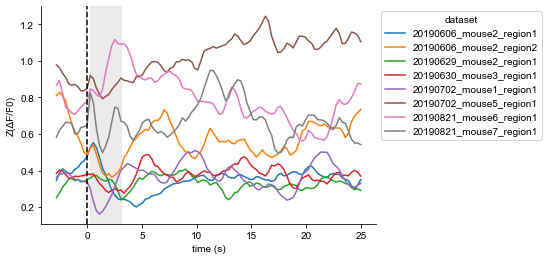

In [27]:
# Plot pop-aggregated, trial-aggregated timeseries by dataset
fig, ax = plt.subplots()
sns.despine(ax=ax)
sns.lineplot(
    ax=ax, 
    data=popagg_timeseries,
    x=Label.TIME,
    y=ykey,
    ci=None,
    color='k',
    hue=Label.DATASET,
)
ax.axvline(0, ls='--', c='k')
ax.axvspan(*resp_tbounds, color='silver', alpha=.3)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))

In [28]:
# # Average across trials
# trialagg_popagg_timeseries = aggregate_along(popagg_timeseries, level=Label.TRIAL, aggfunc=np.mean)

# # Align to stimulus onset
# trialagg_popagg_timeseries[ykey] = align_at(trialagg_popagg_timeseries[ykey], FrameIndex.STIM)

# # Offset by run
# trialagg_popagg_timeseries[ykey] = offset_by(
#     trialagg_popagg_timeseries[ykey], by=Label.RUN, rel_gap=0)

# # Plot trial-aggregated timeseries, by dataset and ISPTA
# logger.info('plotting trial-aggregated timeseries by dataset and ISPTA')
# for hue in [Label.TRIAL, None]:
#     fg = sns.relplot(
#         kind='line',
#         data=popagg_timeseries,
#         x=Label.TIME,
#         y=ykey,
#         ci=None,
#         row=Label.RUN,
#         col=Label.DATASET,
#         hue=hue,
#         # col_wrap=4,
#         height=3,
#         # aspect=.3,
#     )
#     for ax in fg.axes.ravel():
#         ax.axvline(0, ls='--', c='k')
#         ax.axvspan(*resp_tbounds, color='silver', alpha=.3)
#         ax.set_title('\n'.join(ax.get_title().split('|')))

### Automated search to find optimal band-stop frequency range that maximizes evoked response

In [29]:
# # %%skip $isnotpv

# # Define output metrics
# ykey = Label.ZSCORE

# # Define vectors of low and high cutoff frequencies
# flows = np.linspace(.01, .09, 10).round(3)
# fhighs = np.linspace(.2, .7, 10).round(3)

# # Construct multi-index of frequency bands to filter out
# fbands_idx = pd.MultiIndex.from_product([flows, fhighs], names=['flow (Hz)', 'fhigh (Hz)'])

# # Construct multi-index series to store filtered data output metrics
# evoked_amps = pd.Series(index=fbands_idx, dtype=float)

# # Define key for filtered data
# filtered_key = f'filtered {ykey}'

# # Extract frame rate
# fps = get_singleton(trialagg_stats, Label.FPS)

# # For each frequency band, filter data and compute output metrics
# logger.info(f'computing {get_change_key(ykey)} on filtered data for {len(fbands_idx)} different frequency bands...')
# for fband in tqdm(fbands_idx):
#     # Define BW bandstop filter
#     sos, filterfunc = get_butter_filter_func(fps, fband, kind='stop', verbose=False)

#     # Apply filter to population-averaged data, per dataset and run
#     popagg_timeseries[filtered_key] = (popagg_timeseries[ykey]
#         .groupby([Label.DATASET, Label.RUN])
#         .apply(filterfunc)
#     )
 
#     # Compute evoked response amplitudes for each dataset, run & trial
#     out = compute_evoked_change(popagg_timeseries, filtered_key, verbose=False).mean()

#     # Store mean evoked response amplitude
#     evoked_amps.loc[fband] = out.mean()

# # Plot heatmap of evoked response amplitudes across frequency bands combinations
# fig, ax = plt.subplots()
# sns.heatmap(
#     ax=ax,
#     data=evoked_amps.unstack().T,
#     center=0
# )
# ax.set_title(get_change_key(ykey))

# # Find optimal frequency band yielding maximum evoked response amplitude
# flow_opt, fhigh_opt = evoked_amps.idxmax()
# fband_opt = np.array([flow_opt, fhigh_opt])
# fband_opt_str = f'flow = {flow_opt:.3f} Hz, fhigh = {fhigh_opt:.3f} Hz'
# logger.info(f'optimal frequency band: {fband_opt_str}')

# # # Define frequency band for neural oscillations of interest
# # fband_osc = [0.05, .32]  # Hz

# # Plot optimal frequency band on heatmap
# idxlow = np.where(flows == flow_opt)[0][0]
# idxhigh = np.where(fhighs == fhigh_opt)[0][0]
# ax.scatter([idxlow + .5], [idxhigh + .5], c='r', zorder=20)

# # Filter out oscillations with optimized bandstop filter
# sos, filterfunc = get_butter_filter_func(fps, fband_opt, kind='stop')
# popagg_timeseries[filtered_key] = (popagg_timeseries[ykey]
#     .groupby([Label.DATASET, Label.RUN])
#     .apply(filterfunc)
# )

# # Plot timecourse of raw vs filtered data 
# fig, ax = plt.subplots()
# ax.set_title(f'{get_change_key(ykey)}: raw vs filtered with ({fband_opt_str}) bandstop filter')
# sns.despine(ax=ax)
# for yk in [ykey, filtered_key]:
#     sns.lineplot(
#         ax=ax, 
#         data=popagg_timeseries,
#         x=Label.TIME,
#         y=yk,
#         label=yk,
#         ci=None,
#     )
# ax.axvline(0, ls='--', c='k')
# ax.axvspan(*resp_tbounds, color='silver', alpha=.3);

### Manual exploration to find frequency band that best filters out oscillations while preserving response

 30/06/2023 18:40:12: optimal frequency band: flow = 0.010 Hz, fhigh = 0.150 Hz
 30/06/2023 18:40:12: defining order 2 bandstop BW filter with fc = 0.010 Hz - 0.150 Hz


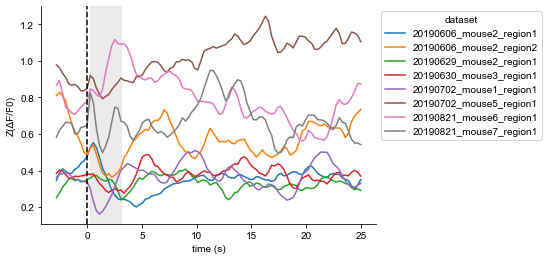

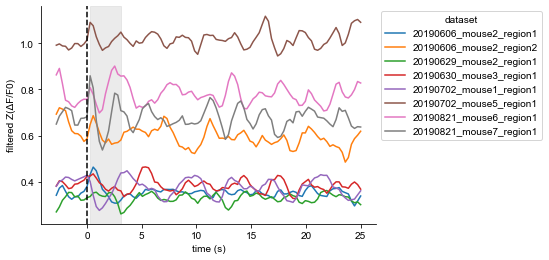

In [30]:
# Define frequency band for neural oscillations of interest
myfband = [0.01, .15]  # Hz
myfband_str = f'flow = {myfband[0]:.3f} Hz, fhigh = {myfband[1]:.3f} Hz'
logger.info(f'optimal frequency band: {myfband_str}')

# Define key for filtered data
filtered_key = f'filtered {ykey}'

# Filter out oscillations with optimized bandstop filter
sos, filterfunc = get_butter_filter_func(fps, myfband, kind='stop')
popagg_timeseries[filtered_key] = (popagg_timeseries[ykey]
    .groupby([Label.DATASET, Label.RUN])
    .apply(filterfunc)
)

# Plot pop-aggregated, trial-aggregated filtered timeseries by dataset, for both raw and filtered data
for yk in [ykey, filtered_key]:
    fig, ax = plt.subplots()
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax, 
        data=popagg_timeseries,
        x=Label.TIME,
        y=yk,
        ci=None,
        color='k',
        hue=Label.DATASET,
    )
    ax.axvline(0, ls='--', c='k')
    ax.axvspan(*resp_tbounds, color='silver', alpha=.3)
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))

 30/06/2023 18:40:14: aligning Z(ΔF/F0) traces at frame 10...
 30/06/2023 18:40:26: aligning filtered Z(ΔF/F0) traces at frame 10...


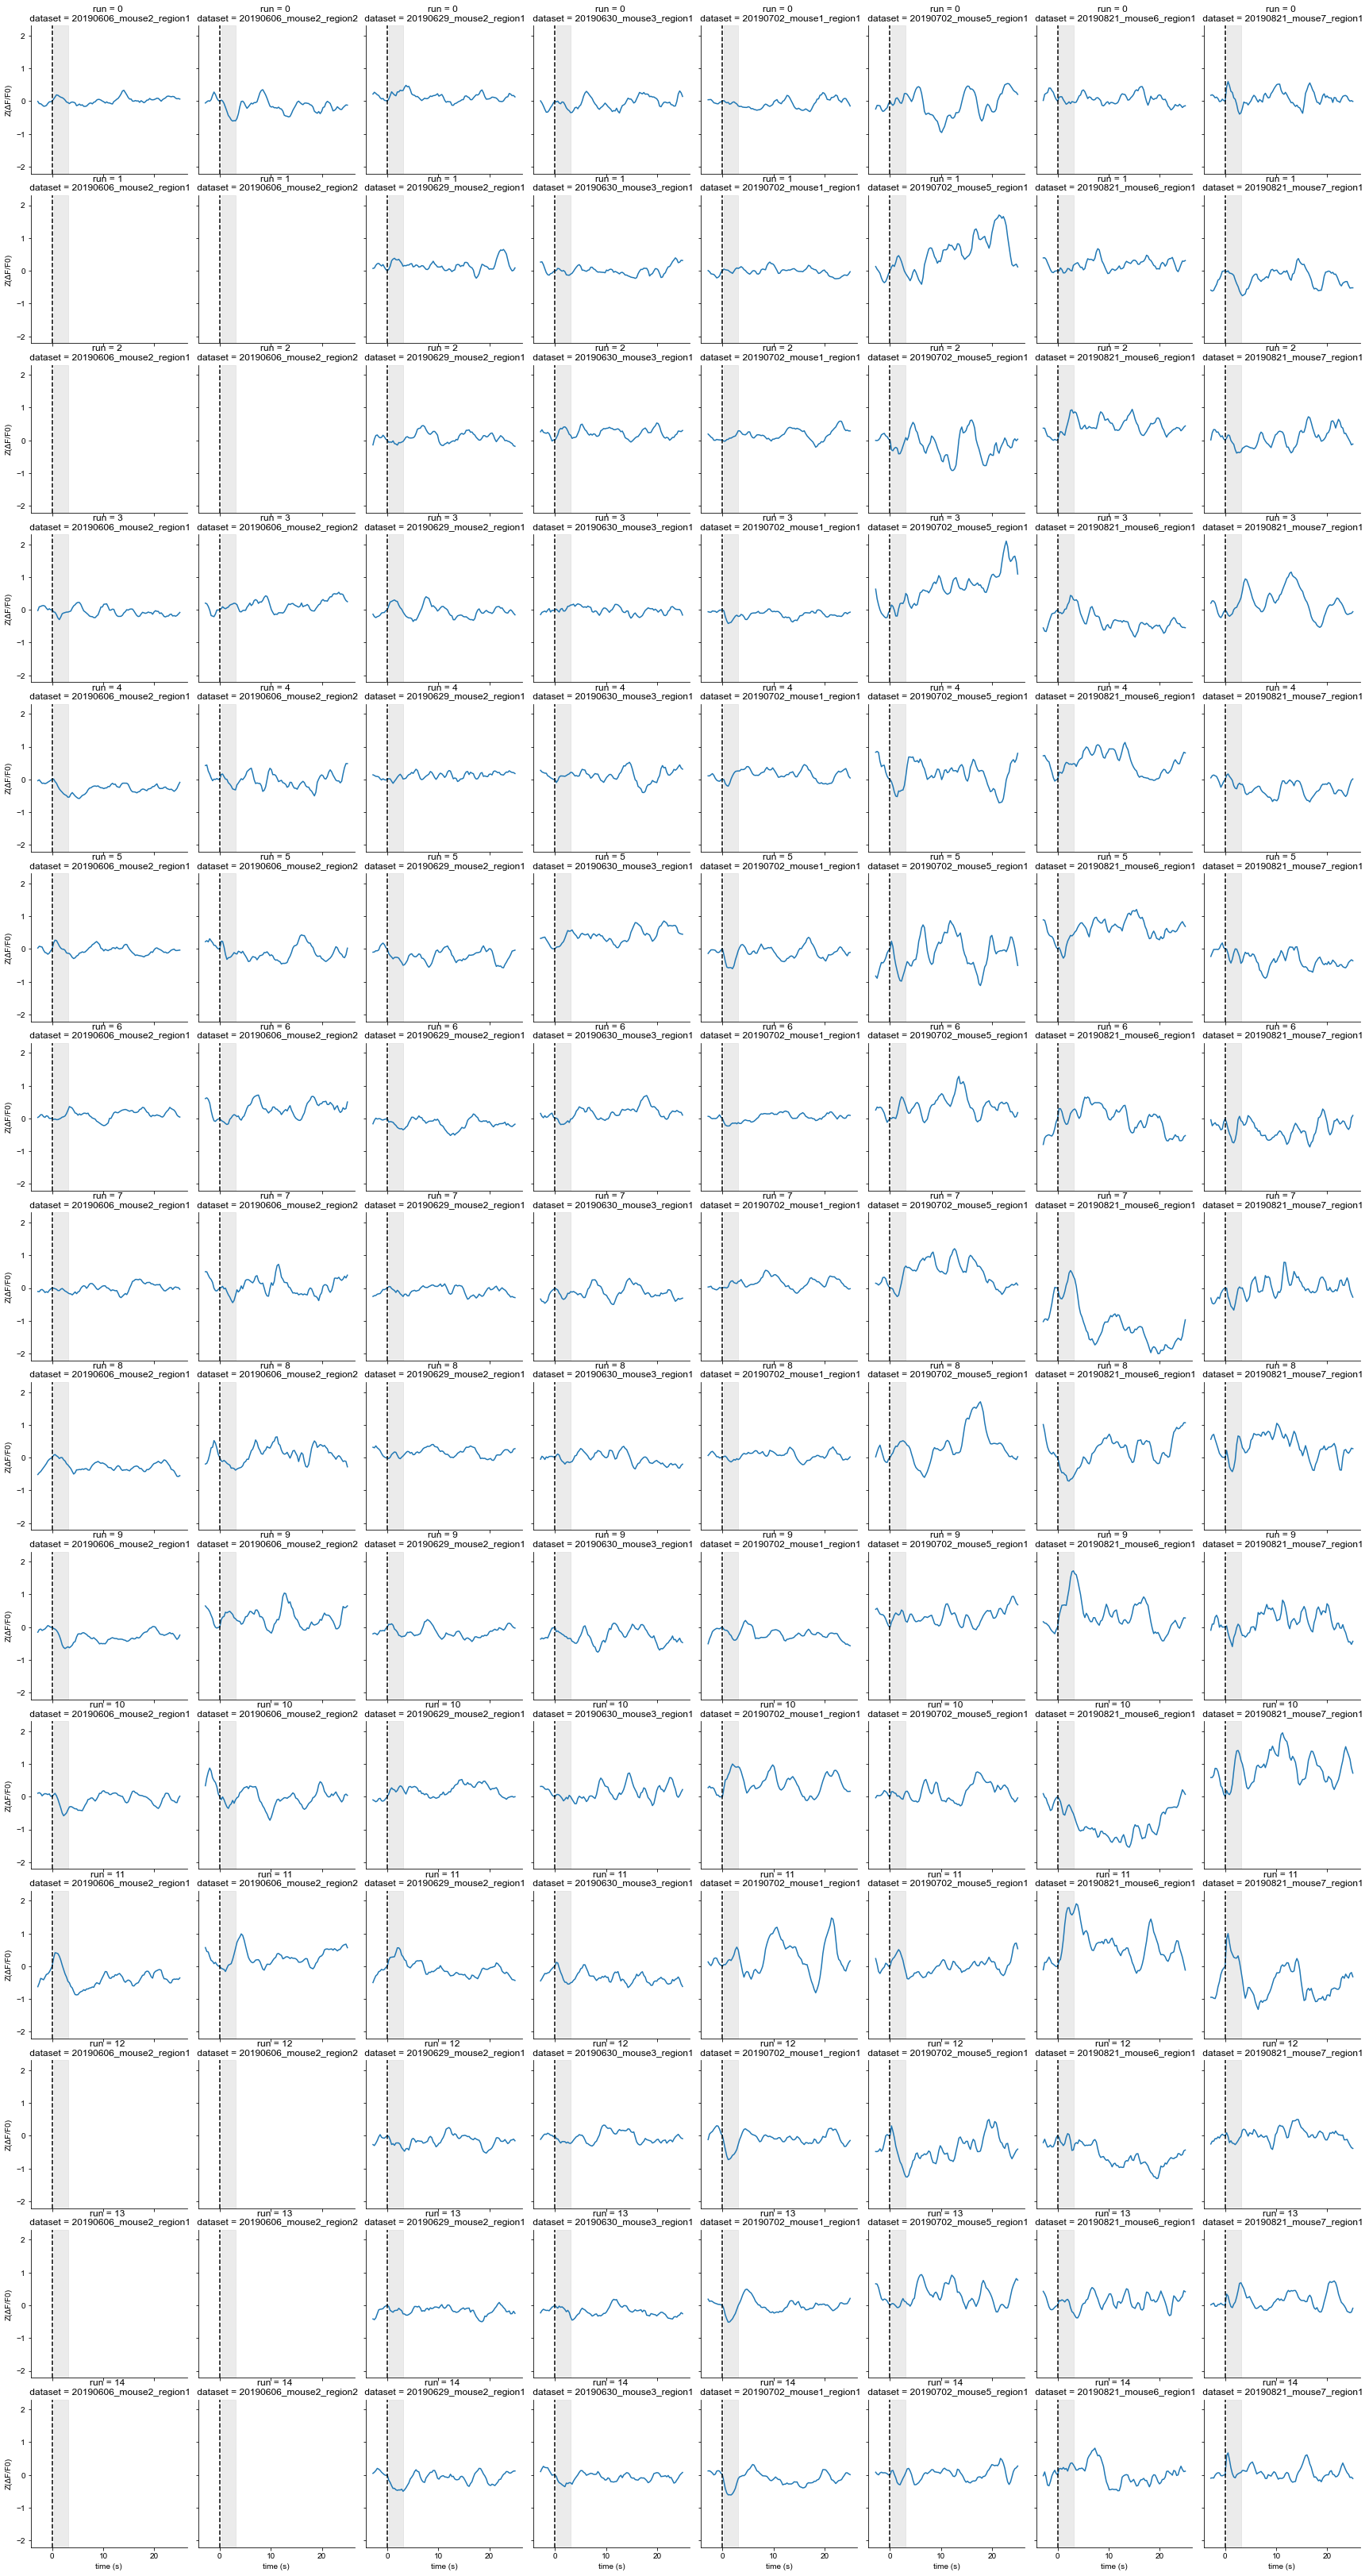

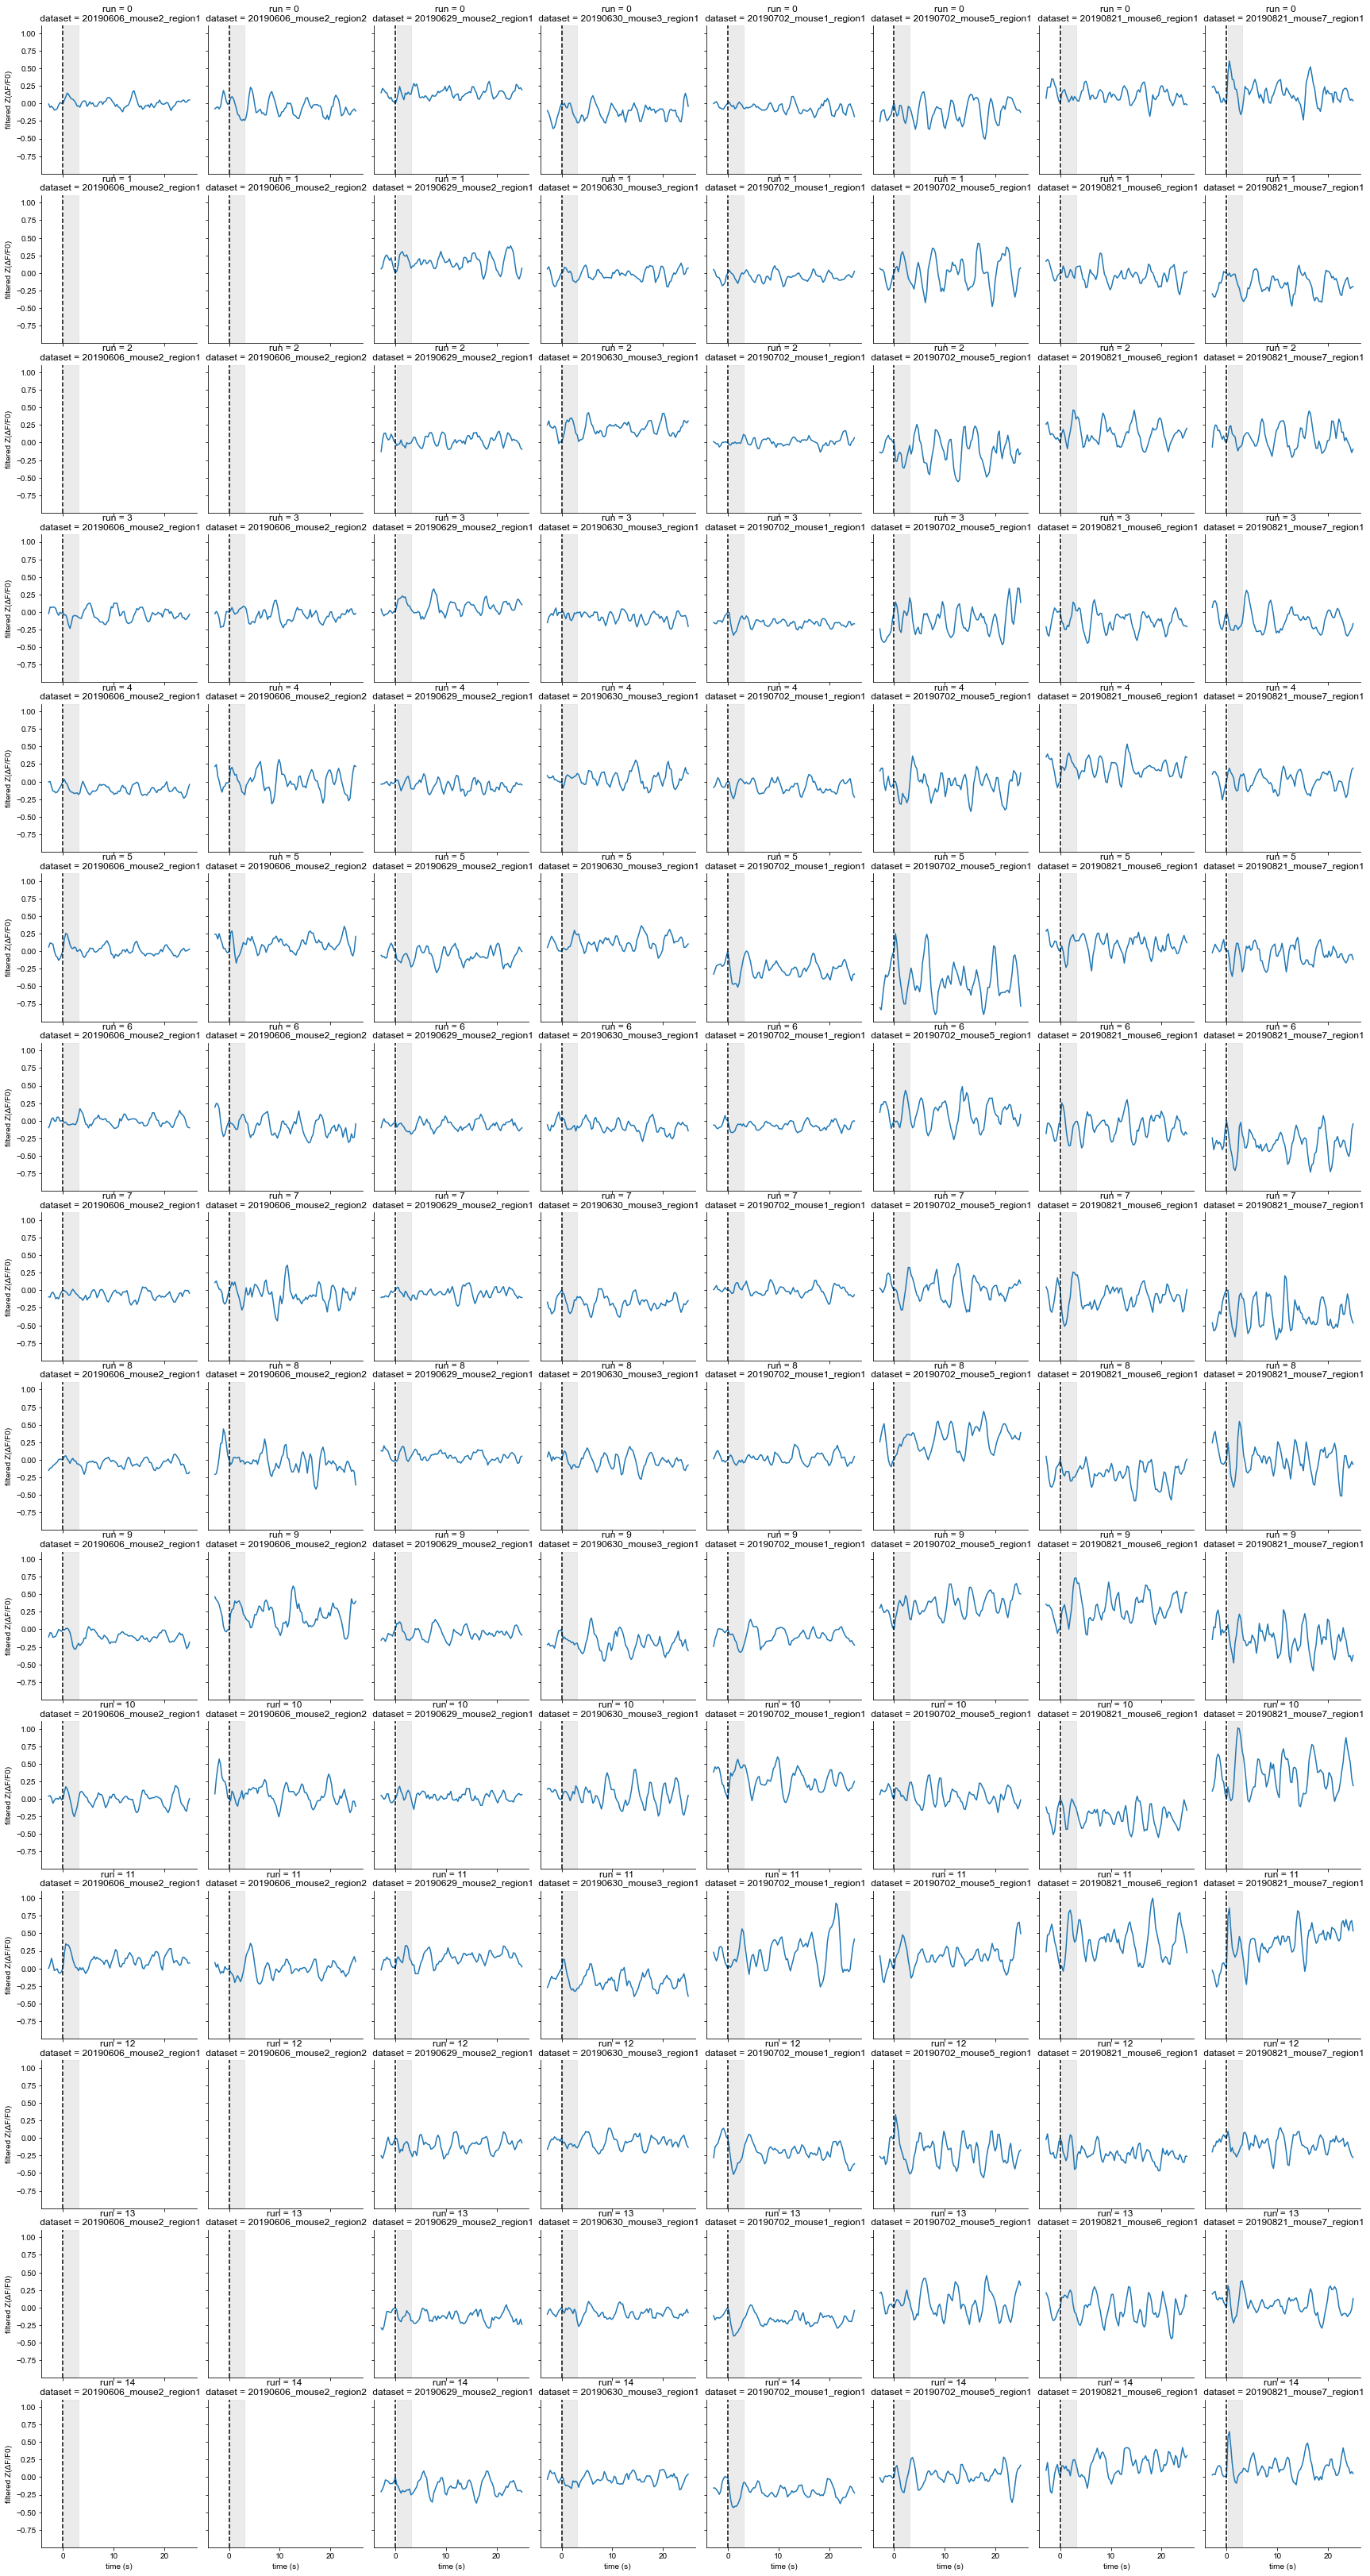

In [31]:
# Plot pop-aggregated, trial-aggregated filtered timeseries by dataset
for yk in [ykey, filtered_key]:

    tmp = popagg_timeseries.copy()
    # tmp = tmp.groupby([Label.DATASET, Label.RUN, Label.FRAME]).mean()
    tmp[yk] = align_at(tmp[yk], FrameIndex.STIM)
    # tmp[yk] = offset_by(tmp[yk], by=Label.RUN)

    fg = sns.relplot(
        kind='line',
        data=tmp,
        x=Label.TIME,
        y=yk,
        ci=None,
        row=Label.RUN,
        col=Label.DATASET,
        hue=None,
        # col_wrap=4,
        height=3,
        # aspect=.3,
    )
    for ax in fg.axes.ravel():
        ax.axvline(0, ls='--', c='k')
        ax.axvspan(*resp_tbounds, color='silver', alpha=.3)
        ax.set_title('\n'.join(ax.get_title().split('|')))

 30/06/2023 18:40:51: applying mean function on Z(ΔF/F0) in [5-10] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on Z(ΔF/F0) in [11-21] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on filtered Z(ΔF/F0) in [5-10] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on filtered Z(ΔF/F0) in [11-21] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on Z(ΔF/F0) in [5-10] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on Z(ΔF/F0) in [11-21] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on filtered Z(ΔF/F0) in [5-10] index window across dataset, run, trial ...
 30/06/2023 18:40:51: applying mean function on filtered Z(ΔF/F0) in [11-21] index window across dataset, run, trial ...
 30/06/2023 18:40:51: expanding (15 runs) input dataframe to match (8 da

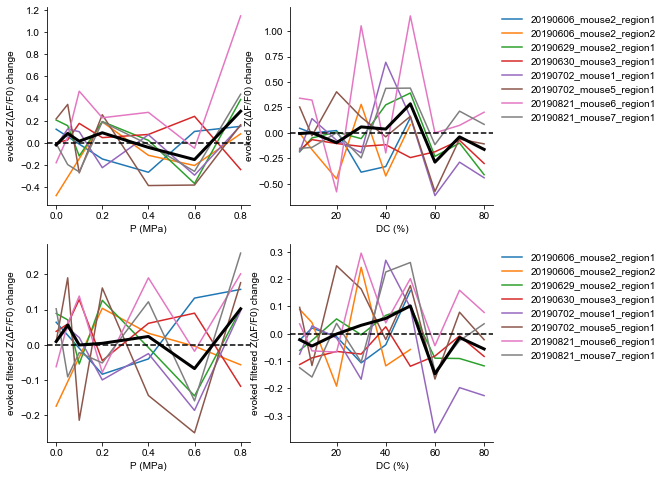

In [32]:
%%skip $isnotpv

ykeys = [ykey, filtered_key]
tmp1 = compute_evoked_change(popagg_timeseries, ykey)
tmp2 = compute_evoked_change(popagg_timeseries, filtered_key)
tmp = pd.concat([compute_evoked_change(popagg_timeseries, yk) for yk in ykeys], axis=1)
tmp = free_expand_and_add(get_params_by_run(trialagg_stats), tmp)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sns.despine(fig=fig)
for yk, axrow in zip(ykeys, axes):
    for xkey, ax in zip([Label.P, Label.DC], axrow):
        for hue in [Label.DATASET, None]:
            sns.lineplot(
                ax=ax,
                data=get_xdep_data(tmp, xkey),
                x=xkey,
                y=get_change_key(yk),
                hue=hue,
                legend=xkey==Label.DC,
                ci=None,
                color='k' if hue is None else None,
                lw=3 if hue is None else None, 
            )
        ax.axhline(0, ls='--', c='k')
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
# harmonize_axes_limits(axes.ravel())

# # fig = plot_parameter_dependency(
# #     data=tmp, xkey=Label.P, ykey=filtered_key)

In [33]:
# # %%skip $isnotpv

# # Plot timecourses and frequency spectra across runs, for original and filtered data
# nrows = popagg_timeseries.groupby(Label.DATASET).ngroups
# figs[f'popagg {ykey} metrics'], axes = plt.subplots(
#     nrows, 2, figsize=(15, 7 * nrows), 
#     gridspec_kw=dict(width_ratios=(1, .2))
# )
# ykeys = [filtered_key]
# groups = popagg_timeseries.groupby(Label.DATASET)
# logger.setLevel(logging.WARNING)
# for axrow, (dadaset_id, gdata) in tqdm(zip(axes, groups)):
#     mydata = gdata.reset_index(level=Label.DATASET, drop=True)
#     plot_popagg_timecourse(
#         mydata, ykeys, fps, ax=axrow[0], legend=False)
#     plot_popagg_frequency_spectrum(
#         mydata, ykeys, fps, fmax=fmax, ax=axrow[1],
#         # fband=fband_osc, fband_color={'stop': 'r', 'pass': 'g'}[fkind], 
#     )
#     sns.move_legend(axrow[1], 'upper left', bbox_to_anchor=(1, 1), frameon=False)
#     axrow[0].set_title(dadaset_id.replace('_', ' '))
# logger.setLevel(logging.INFO)
# figs[f'popagg {ykey} metrics'].subplots_adjust(hspace=0.3)

### Examine variability of responses

In [34]:
%%skip True
# Get fraction of responders for each dataset, run & trial
ext_resp_props = get_responders_counts(
    ext_stats, Label.RUN, units=[Label.DATASET, Label.TRIAL], normalize=True)

# Plot distirbution of responder fraction across datasets & trial, per condition
sns.catplot(
    data=ext_resp_props.reset_index(Label.RUN),
    kind='box',
    y='positive',
    x=Label.RUN,
    height=4,
    aspect=2
)

# Compute population-average stats for each trial 
popagg_stats = (
    ext_stats[[ykey_diff, Label.ISPTA, Label.RUNID]]
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
)
popagg_stats[Label.RUNID] = popagg_stats[Label.RUNID].astype(int)

# testdata = ext_resp_props['positive']
testdata = ext_stats[ykey_diff]
testgroupby = [Label.RUN, Label.DATASET]
pthr = PTHR_DETECTION

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f'tests on {testdata.name} distributions')
sns.despine(fig=fig)
histkwargs = dict(
    x='pval',
    bins=np.linspace(0, 1, 21),
    stat='density',
    hue='H0'
)
# Test if distributions are normal
from scipy.stats import normaltest
isnormal = apply_test(
    testdata, testgroupby, normaltest, pthr=pthr)
axes[0].set_title('normal test (H0: normal)')
sns.histplot(
    ax=axes[0],
    data=isnormal,
    **histkwargs
)

# Test if distributions are multimodal
from diptest import diptest
ismultimodal = apply_test(
    testdata, testgroupby, diptest, pthr=pthr)
axes[1].set_title('dip test (H0: unimodal)')
sns.histplot(
    ax=axes[1],
    data=ismultimodal,
    **histkwargs
)

In [35]:
%%skip True
# For each dataset, compute 2-way ANOVA for trial vs. ROI
Ftable = ext_stats[ykey_diff].groupby(Label.DATASET).agg(compute_ROI_vs_trial_anova)
Ftable = pd.DataFrame(
    Ftable.tolist(),
    columns=[f'F({Label.TRIAL})', f'F({Label.ROI})'],
    index=Ftable.index
)
# Plot resulting F-scores on 2D scatter graph
fig, ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    data=Ftable,
    x=f'F({Label.TRIAL})',
    y=f'F({Label.ROI})',
    ax=ax
)
xymax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(0, xymax)
ax.set_ylim(0, xymax)
ax.axline((0, 0), (1, 1), ls='--', color='k')
ax.set_aspect(1.)

### Plot trial heatmap per condition for entire mouse line

In [36]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

### Plot response traces

In [37]:
%%skip $skip_traces

# Get plot-ready traces dataset
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Align DFF and z-score traces w.r.t their pre-stimulus average
plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
    plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None # Label.ROI_RESP_TYPE

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent and dutcy cycle dependent response traces, per dataset
    for pkey in pkeys:
        figs.update(
            plot_responses_across_datasets(
                plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []  
    for pkey in pkeys:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True, groupby=groupby)
        avgaxes = avgaxes + figs[f'{ykey} vs. {pkey} by type'].axes
    harmonize_axes_limits(avgaxes)

## Exports

### Save responder-type-averaged stats to disk

In [38]:
# Define resp prop extraction function
respprops_func = lambda df: get_responders_counts(
    df, Label.RUN, units=Label.DATASET, normalize=True)

# Get resp fractions by dataset, run and responder type
resp_props_by_type = trialagg_stats.groupby(Label.ROI_RESP_TYPE).apply(respprops_func)
weights = resp_props_by_type.pop('weight')
weighted_resp_props = resp_props_by_type.multiply(weights, axis=0).groupby([Label.ROI_RESP_TYPE, Label.RUN]).sum()
resp_props_sem = resp_props_by_type.groupby([Label.ROI_RESP_TYPE, Label.RUN]).sem()
resp_frac_by_type = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Get overall resp fractions by dataset and run
resp_props_all = respprops_func(trialagg_stats)
weights = resp_props_all.pop('weight')
weighted_resp_props = resp_props_all.multiply(weights, axis=0).groupby(Label.RUN).sum()
resp_props_sem = resp_props_all.groupby(Label.RUN).sem()
resp_frac_all = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Merge the two datasets
resp_frac_stats = (
    pd.concat([
        resp_frac_by_type, 
        resp_frac_all
            .assign(**{Label.ROI_RESP_TYPE: 'all'})
            .set_index(Label.ROI_RESP_TYPE, append=True)
            .reorder_levels([Label.ROI_RESP_TYPE, Label.RUN])
    ], axis=0)
    .add_prefix(f'{Label.RESP_FRAC} - ')
)

# Extract output directory for line-aggregated data
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)

# For each error propagation type
for errprop in ['intra', 'inter']:
    # Determine output file path
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    # Extract line-aggregated data
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    # Add information about responder types
    lineagg_stats = pd.concat([lineagg_stats, resp_frac_stats], axis=1)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

 30/06/2023 18:40:52: run not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:40:52: run not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:40:52: run not part of (P (MPa), DC (%)) -> no filtering
 30/06/2023 18:40:52: computing ROI-weighted average of (8 datasets x 357 ROIs x 15 runs) dataframe across run...
 30/06/2023 18:40:52: computing ROI-weighted average of (8 datasets x 357 ROIs x 15 runs) dataframe across run...
 30/06/2023 18:40:52: saving line-aggregated stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/pv_intra.csv...
 30/06/2023 18:40:52: computing ROI-weighted average of (8 datasets x 357 ROIs x 15 runs) dataframe across run...
 30/06/2023 18:40:52: computing ROI-weighted average of (8 datasets x 357 ROIs x 15 runs) dataframe across run...
 30/06/2023 18:40:52: saving line-aggregated stats to /Users/tlemair

### Save figures

In [39]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 30/06/2023 18:40:53: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.06.30/figs_main_pv_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


### Notify upon completion

In [40]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 30/06/2023 18:41:22: pv batch notebook completed in 0:02:00.687391 s
